# 3D fitting of HESS J1825-137 and HESS J1826-130 region

In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
# import tabulate
import os
from pathlib import Path
import scipy
from scipy import special
from scipy.stats import chi2
from scipy.stats import norm
import scipy.stats as stats
from regions import CircleSkyRegion

from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
import astropy.units as u
import math

In [2]:
from gammapy.data import DataStore
from gammapy.makers.utils import make_theta_squared_table
from gammapy.visualization import plot_theta_squared_table
from gammapy.modeling import Fit
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
    MapDatasetOnOff)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    ExpCutoffPowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    GaussianSpatialModel,
    GeneralizedGaussianSpatialModel,
    DiskSpatialModel,
    FoVBackgroundModel,
    LogParabolaSpectralModel,
    Models)
from gammapy.maps import Map, MapAxis, WcsNDMap, WcsGeom, RegionGeom
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    FoVBackgroundMaker)
from gammapy.modeling import Fit
from gammapy.estimators import TSMapEstimator, FluxPointsEstimator
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.estimators import ExcessMapEstimator, FluxPoints

In [3]:
#
figsize=(12,9)
dpi = 300
# lowE, highE = 1.3, 100.0# Elow, Ehigh = 1.0, 100.0
lowE, highE = 2.0, 120.0
#1.3, 1.8, 2.4
correlation_radius = 0.07
gaus_width = "0.03 deg"
sigma_lvl1, sigma_lvl2 = 5, 10
cut = 3/0.02
center = 150
MapCenter = SkyCoord(ra=276*u.deg,dec=-13.5*u.deg)
PlotMapHalfWidth = 2*u.deg
#
lw, mew = 1.5, 2
label_markersize = 12
lable_fontsize = 12
plot_markersize = 15
plot_text_fontsize = 15
framealpha = 0.7
xylabel_fontsize = 15
tick_fontsize = 14
title_fontsize = 16

### Define analysis directory and read dataset from disk

In [4]:
# catalog_filename = "/home/visitor_ap3/bridge_he/catalog/hgps_catalog_v1.fits"
catalog_filename = "/home/khelifi/HESS/data/HGPS/hgps_catalog_v1.fits.gz"
# output = "/home/visitor_ap3/bridge_he/3D_fitting"
output = "/home/khelifi/MesProgrammes/pyperso/HESSJ1825_HESSJ1826/3D_fitting_BKH"
# bridge_comp = "/home/visitor_ap3/bridge_he/bridge_comp"
bridge_comp = "/home/khelifi/MesProgrammes/pyperso/HESSJ1825_HESSJ1826/bridge_comp_BKH"

path = Path("/home/khelifi/MesProgrammes/pyperso/HESSJ1825_HESSJ1826/dataset")
# filename = path / "reduced_dataset_iter4.fits.gz"
filename = path / "reduced_dataset_iter1.fits.gz"
stacked = MapDataset.read(filename, name='stacked')
stacked = stacked.slice_by_energy(lowE * u.TeV, highE * u.TeV, name='stacked')


bkg_model = FoVBackgroundModel(dataset_name="stacked")
models = Models([bkg_model])

stacked.models = models


print(stacked)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 33909 
  Total background counts         : 31025.15
  Total excess counts             : 2883.85

  Predicted counts                : 31025.15
  Predicted background counts     : 31025.15
  Predicted excess counts         : 0.00

  Exposure min                    : 4.92e-03 m2 s
  Exposure max                    : 6.22e+10 m2 s

  Number of total bins            : 1440000 
  Number of fit bins              : 1035248 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 236569.51

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : stacked-bkg
    Datasets names            : ['stacked']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :      1.000   +/-    0.00             
 

In [5]:
stacked.counts.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

## Find peaks above 5 sigma

In [6]:
estimator = ExcessMapEstimator(
    correlation_radius=0.1 * u.deg,
    selection_optional=[])
lima_maps = estimator.run(stacked)

significance_map = lima_maps["sqrt_ts"]
sqrt_ts_image = significance_map.get_image_by_idx((0,))

In [7]:
threshold, min_distance = 5, 0.22
sources = find_peaks(
    sqrt_ts_image,
    threshold=threshold,
    min_distance=min_distance * u.deg)
sources

value,x,y,ra,dec
,,,deg,deg
float32,int64,int64,float64,float64
12.258,192,204,276.60439,-13.68995
7.7313,195,147,276.54309,-14.82998
6.7814,224,207,275.94580,-13.62949
6.7215,197,239,276.50131,-12.98999
5.3435,240,200,275.61603,-13.76860
5.2894,200,166,276.43967,-14.45000


In [8]:
source_pos = SkyCoord(sources["ra"], sources["dec"])
source_pos

<SkyCoord (ICRS): (ra, dec) in deg
    [(276.60438583, -13.68995186), (276.54308561, -14.82998259),
     (275.94580307, -13.62948646), (276.50130826, -12.98999467),
     (275.61603428, -13.76859588), (276.43967403, -14.44999979)]>

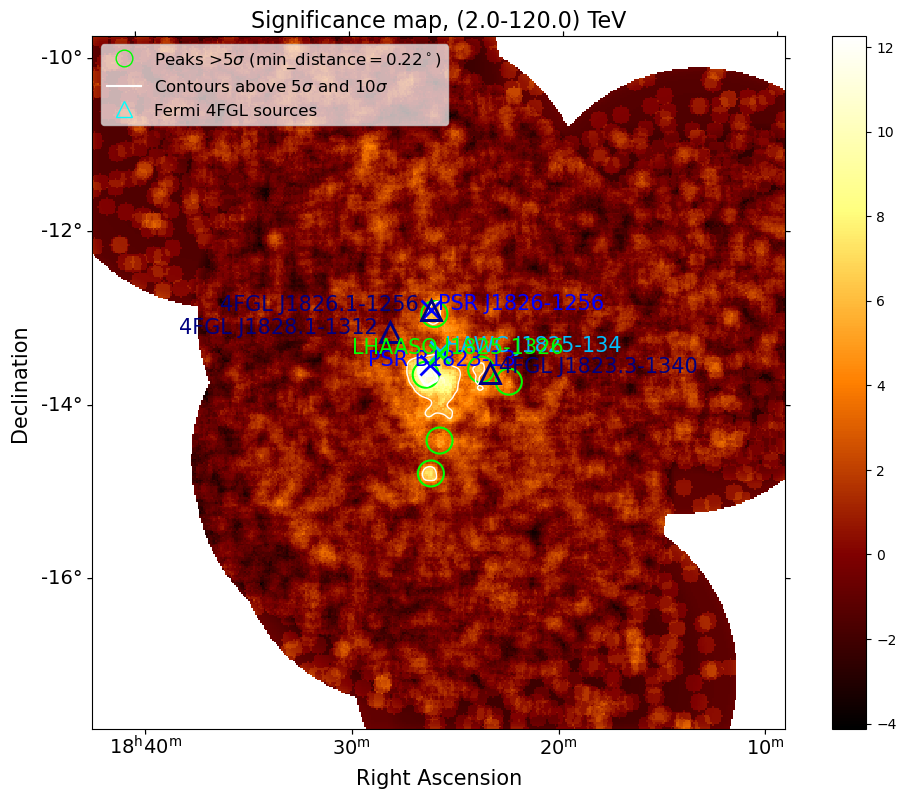

In [9]:
fig = plt.figure(figsize=figsize)
fig.tight_layout()

# sqrt_ts_image = the_sqrt_ts_image.cutout(position=PlotMapHalfWidth, width=PlotMapHalfWidth)

ax = plt.subplot(111, projection=sqrt_ts_image.geom.wcs)
sqrt_ts_image.plot(ax=ax, add_cbar=True)


plt.contour(sqrt_ts_image.smooth(width=gaus_width).data,
           levels=[sigma_lvl1, sigma_lvl2], colors=['white'], linewidths=[1, 2])

#plt.contour(sqrt_ts_image.smooth(width=gaus_width).data,
#           levels=[sigma_lvl1, sigma_lvl2], colors=['white'], linewidths=[1, 2])


#Radio position of PSR J1826-1256
ax.plot(276.536 * u.deg, -12.943 * u.deg, color='blue', 
        fillstyle='none', marker="x", linestyle='dashed', mew=mew,
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'), label='PSR B1826-1256')
ax.text(276.536-0.12, -12.943, 'PSR J1826-1256',
        transform=ax.get_transform("icrs"),
        color='blue', fontsize=plot_text_fontsize)


#Radio position of PSR B1823-13
ax.plot(276.554 * u.deg, -13.58 * u.deg, color='blue', 
        fillstyle='none', marker="x", linestyle='dashed', mew=mew,
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'), label='PSR B1823-13')
ax.text(276.554+0.73, -13.58, 'PSR B1823-13',
        transform=ax.get_transform("icrs"),
        color='blue', fontsize=plot_text_fontsize)

#HAWC position of HAWC J1825-134
ax.plot(276.44 * u.deg, -13.42 * u.deg, color='deepskyblue', 
        fillstyle='none', marker="x", linestyle='dashed', mew=mew,
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'))
ax.text(276.44-0.070, -13.42, 'HAWC J1825-134',
        transform=ax.get_transform("icrs"),
        color='deepskyblue', fontsize=plot_text_fontsize)

#LHAASO position of LHAASO J1825-1326
ax.plot(276.45 * u.deg, -13.45 * u.deg, color='lime', 
        fillstyle='none', marker="x", linestyle='dashed', mew=mew, 
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'))
ax.text(276.45+1.03, -13.45, 'LHAASO J1825-1326',
        transform=ax.get_transform("icrs"),
        color='lime', fontsize=plot_text_fontsize)

#Fermi 4FGL sources around HESS J1825-137
ax.plot(277.0276 * u.deg, -13.2019 * u.deg, color='navy', fillstyle='none', marker="^",  mew=mew,
        linewidth=lw, markersize=plot_markersize, transform=ax.get_transform('icrs'), label='4FGL J1828.1-1312')
ax.text(277.0276+2.5, -13.2019, '4FGL J1828.1-1312',
        transform=ax.get_transform("icrs"),
        color='navy', fontsize=plot_text_fontsize)
ax.plot(276.5352 * u.deg, -12.9415 * u.deg, color='navy', fillstyle='none', marker="^",  mew=mew,
        linewidth=lw, markersize=plot_markersize, transform=ax.get_transform('icrs'), label='4FGL J1826.1-1256')
ax.text(276.5352+2.5, -12.9415, '4FGL J1826.1-1256',
        transform=ax.get_transform("icrs"),
        color='navy', fontsize=plot_text_fontsize)
ax.plot(275.8363 * u.deg, -13.6676 * u.deg, color='navy', fillstyle='none', marker="^",  mew=mew,
        linewidth=lw, markersize=plot_markersize, transform=ax.get_transform('icrs'), label='4FGL J1823.3-1340')
ax.text(275.8363-0.1, -13.6676, '4FGL J1823.3-1340',
        transform=ax.get_transform("icrs"),
        color='navy', fontsize=plot_text_fontsize)


plt.gca().scatter(
    source_pos.ra.deg,
    source_pos.dec.deg,
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="lime",
    marker="o",
    s=350,
    lw=lw)


# ax.set_xlim(center-cut/2,center+cut/2)
# ax.set_ylim(center-cut/2,center+cut/2)
# ax.set_xlim(276-3/2,276+3/2)
# ax.set_ylim(-13.5-3/2,-13.5+3/2)

legend_elements = [Line2D([0], [0], marker="o", color='none', 
                          label=os.path.join('Peaks >{}$\sigma$ (min_distance$={}^{}$)'.
                                             format(threshold, min_distance, '\circ')),
                          markeredgecolor='lime', markersize=label_markersize),
                   Line2D([0], [0], color='white', label=os.path.join('Contours above {}$\sigma$ and {}$\sigma$').
                          format(sigma_lvl1, sigma_lvl2),markeredgecolor='white', markersize=label_markersize),
                  Line2D([0], [0], marker="^", color='none', label='Fermi 4FGL sources',
                          markeredgecolor='cyan', markersize=label_markersize)]
ax.legend(handles=legend_elements, fancybox=True, framealpha=framealpha, loc = 'upper left', fontsize=lable_fontsize)
ax.set_title(os.path.join('Significance map, ({}-{}) TeV'.format(lowE, highE)), fontsize=title_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.set_xlabel('Right Ascension', fontsize=xylabel_fontsize)
ax.set_ylabel('Declination', fontsize=xylabel_fontsize)
#plt.rcParams['axes.linewidth'] = 1.5

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.savefig(os.path.join(output,'sign_map_{}_{}_{}_{}_radius_{}_he.png'.format(
   lowE, highE, threshold, min_distance, correlation_radius)), 
          dpi=dpi, bbox_inches='tight')
plt.show()

In [78]:
# J1825 LHAASO (2020) - 0.30 ± 0.06 20-500TeV
LHAASO_J1825 = LogParabolaSpectralModel(
    amplitude = "6.875e-14 TeV-1 cm-2 s-1", # 1.1e-11 erg cm-2 s-1 @10TeV -> 1.1e-11/(1.6*10)/10=6.875e-14
    alpha = 0.92,
    beta = 1.19,
    reference = "10 TeV",
)
LHAASO_J1825_spatial_model = GaussianSpatialModel(
    lon_0=276.45*u.deg, 
    lat_0=-13.45*u.deg, 
    sigma=0.3*u.deg,
    e=0.0, 
    phi=0*u.deg,
    frame="icrs")

# J1825 HAWC (2021) - 0.47
#https://iopscience.iop.org/article/10.3847/2041-8213/abd77b/pdf - 1.200TeV
HAWC_J1825_138 = ExpCutoffPowerLawSpectralModel(  #0.47+/-0.04 deg - 0.5/50
    amplitude = "4.5e-14 TeV-1 cm-2 s-1",
    index = 2.02,
    lambda_ = 0.0370 * u.Unit("TeV-1"),
    reference = "18 TeV",
)
HAWC_J1825_138.parameters['index'].error = 0.15
HAWC_J1825_138.parameters['amplitude'].error = 1.15e-14 * u.Unit("cm-2 s-1 TeV-1")
HAWC_J1825_138.parameters['lambda_'].error = 0.011 * u.Unit("TeV-1")
HAWC_J1825_138_spatial_model = GaussianSpatialModel(
    lon_0=276.38*u.deg, 
    lat_0=-13.86*u.deg, 
    sigma=0.47*u.deg,
    e=0.0, 
    phi=0*u.deg,
    frame="icrs")

HAWC_J1825_134 = PowerLawSpectralModel(   #YSC? Point Source, associated with  HESS J1825-137 
    amplitude = "4.2e-15 TeV-1 cm-2 s-1",
    index = 2.28,
    reference = "18 TeV",
)
HAWC_J1825_134.parameters['index'].error = 0.12
HAWC_J1825_134.parameters['amplitude'].error = 1.25e-15 * u.Unit("cm-2 s-1 TeV-1")

HAWC_J1826_128 = ExpCutoffPowerLawSpectralModel(  #0.20+/-0.03 deg
    amplitude = "2.7e-14 TeV-1 cm-2 s-1",
    index = 1.2,
    lambda_ = 0.0417 * u.Unit("TeV-1"),
    reference = "18 TeV",
)
HAWC_J1826_128.parameters['index'].error = 0.4
HAWC_J1826_128.parameters['amplitude'].error = 0.95e-15 * u.Unit("cm-2 s-1 TeV-1")
HAWC_J1826_128.parameters['lambda_'].error = 0.0147 * u.Unit("TeV-1")
HAWC_J1826_128_spatial_model = GaussianSpatialModel(
    lon_0=276.5*u.deg, 
    lat_0=-12.86*u.deg, 
    sigma=0.2*u.deg,
    e=0.0, 
    phi=0*u.deg,
    frame="icrs")

## Modeling and fitting the region

### HESS J1825-137 peak as a gaussian

In [10]:
#HESS J1826-130 as Gaussian
HESS_J1826_130_spatial_model = GaussianSpatialModel(
    lon_0=276.496*u.deg, 
    lat_0=-13.008*u.deg, 
    sigma=0.18*u.deg,
    frame="icrs")
HESS_J1826_130_spectral_model = ExpCutoffPowerLawSpectralModel(
    amplitude="7.87e-13 cm-2 s-1 TeV-1",
    index=1.388 ,
#     lambda_= 0.023 * u.Unit("TeV-1"),
    lambda_= 0.001 * u.Unit("TeV-1"),
    reference=1 * u.TeV)
HESS_J1826_130_model = SkyModel(
    spatial_model=HESS_J1826_130_spatial_model,
    spectral_model=HESS_J1826_130_spectral_model,
    name="HESS J1826-130")
HESS_J1826_130_model.parameters["lon_0"].frozen = False
HESS_J1826_130_model.parameters["lat_0"].frozen = False
HESS_J1826_130_model.parameters["sigma"].frozen = False
HESS_J1826_130_model.parameters["index"].frozen = False
HESS_J1826_130_model.parameters["lambda_"].frozen = False
# HESS_J1826_130_model.parameters["lambda_"].frozen = True
HESS_J1826_130_model.parameters["e"].frozen = False
HESS_J1826_130_model.parameters["phi"].frozen = False
HESS_J1826_130_model.parameters["lambda_"].min = 0.0001
HESS_J1826_130_model.parameters["lambda_"].max = 2
HESS_J1826_130_model.parameters["lon_0"].min = HESS_J1826_130_model.parameters["lon_0"].value-0.2
HESS_J1826_130_model.parameters["lon_0"].max = HESS_J1826_130_model.parameters["lon_0"].value+0.2
HESS_J1826_130_model.parameters["lat_0"].min = HESS_J1826_130_model.parameters["lat_0"].value-0.2
HESS_J1826_130_model.parameters["lat_0"].max = HESS_J1826_130_model.parameters["lat_0"].value+0.2
HESS_J1826_130_model.parameters["amplitude"].min = 1e-16
HESS_J1826_130_model.parameters["amplitude"].max = 1e-8
HESS_J1826_130_model.parameters["index"].min = 0
HESS_J1826_130_model.parameters["index"].max = 10
HESS_J1826_130_model.parameters["sigma"].max = 10


# HESS J1825-137 halo as Gaussian
HESS_J1825_137_halo_spatial_model = GaussianSpatialModel(
    lon_0=276.277*u.deg, 
    lat_0=-13.954*u.deg, 
    sigma=0.541*u.deg,
    e=0.0, 
    phi=0*u.deg,
    frame="icrs")
#HESS_J1825_137_halo_spectral_model = PowerLawSpectralModel(
#    index=2.7,
#    amplitude="1.61e-10 cm-2 s-1 TeV-1")
HESS_J1825_137_halo_spectral_model = ExpCutoffPowerLawSpectralModel(
    amplitude="1.80e-11 cm-2 s-1 TeV-1",
    index=1.444,
#     lambda_=0.139 * u.Unit("TeV-1"),
    lambda_=0.001 * u.Unit("TeV-1"),
    reference=1 * u.TeV)
HESS_J1825_137_halo_model = SkyModel(
    spatial_model=HESS_J1825_137_halo_spatial_model,
    spectral_model=HESS_J1825_137_halo_spectral_model,
    name="HESS J1825-137 halo")
HESS_J1825_137_halo_model.parameters["lon_0"].frozen = False
HESS_J1825_137_halo_model.parameters["lat_0"].frozen = False
HESS_J1825_137_halo_model.parameters["sigma"].frozen = False
HESS_J1825_137_halo_model.parameters["e"].frozen = False
HESS_J1825_137_halo_model.parameters["phi"].frozen = False
HESS_J1825_137_halo_model.parameters["index"].frozen = False
HESS_J1825_137_halo_model.parameters["lambda_"].frozen = False
HESS_J1825_137_halo_model.parameters["amplitude"].min = 1e-16
HESS_J1825_137_halo_model.parameters["amplitude"].max = 1e-8
HESS_J1825_137_halo_model.parameters["index"].min = 0
HESS_J1825_137_halo_model.parameters["index"].max = 10
HESS_J1825_137_halo_model.parameters["sigma"].max = 10
# HESS_J1825_137_halo_model.parameters["lambda_"].min = 0.0001
# HESS_J1825_137_halo_model.parameters["lambda_"].max = 2
HESS_J1825_137_halo_model.parameters["lon_0"].min = HESS_J1825_137_halo_model.parameters["lon_0"].value-0.5
HESS_J1825_137_halo_model.parameters["lon_0"].max = HESS_J1825_137_halo_model.parameters["lon_0"].value+0.5
HESS_J1825_137_halo_model.parameters["lat_0"].min = HESS_J1825_137_halo_model.parameters["lat_0"].value-0.5
HESS_J1825_137_halo_model.parameters["lat_0"].max = HESS_J1825_137_halo_model.parameters["lat_0"].value+0.5


# HESS J1825-137 peak as Gaussian  (276.52205	-13.68999)
HESS_J1825_137_peak_spatial_model = GaussianSpatialModel(
     lon_0=276.52205*u.deg, 
     lat_0=-13.68999*u.deg, 
    sigma=0.189*u.deg,
    e=0.709, 
    phi=74.192*u.deg,
    frame="icrs")
#276.52205	-13.68999 r_0=0.189*u.deg,
HESS_J1825_137_peak_spectral_model = ExpCutoffPowerLawSpectralModel(
    amplitude="2.50e-12 cm-2 s-1 TeV-1",
    index=1.732,
#     lambda_=0.016 * u.Unit("TeV-1"),
    lambda_=0.0 * u.Unit("TeV-1"),
    reference=1 * u.TeV)
HESS_J1825_137_peak_model = SkyModel(
    spatial_model=HESS_J1825_137_peak_spatial_model,
    spectral_model=HESS_J1825_137_peak_spectral_model,
    name="HESS J1825-137 peak")
HESS_J1825_137_peak_model.parameters["lon_0"].frozen = False
HESS_J1825_137_peak_model.parameters["lat_0"].frozen = False
HESS_J1825_137_peak_model.parameters["sigma"].frozen = False
HESS_J1825_137_peak_model.parameters["e"].frozen = False
HESS_J1825_137_peak_model.parameters["phi"].frozen = False
HESS_J1825_137_peak_model.parameters["index"].frozen = False
HESS_J1825_137_peak_model.parameters["lambda_"].frozen = True
#HESS_J1825_137_peak_model.parameters["reference"].frozen = False
HESS_J1825_137_peak_model.parameters["amplitude"].min = 1e-16
HESS_J1825_137_peak_model.parameters["amplitude"].max = 1e-8
HESS_J1825_137_peak_model.parameters["index"].min = 0
HESS_J1825_137_peak_model.parameters["index"].max = 10
HESS_J1825_137_peak_model.parameters["sigma"].max = 10
# HESS_J1825_137_peak_model.parameters["lambda_"].min = 0.0001
# HESS_J1825_137_peak_model.parameters["lambda_"].max = 2
HESS_J1825_137_peak_model.parameters["lon_0"].min = HESS_J1825_137_peak_model.parameters["lon_0"].value-0.5
HESS_J1825_137_peak_model.parameters["lon_0"].max = HESS_J1825_137_peak_model.parameters["lon_0"].value+0.5
HESS_J1825_137_peak_model.parameters["lat_0"].min = HESS_J1825_137_peak_model.parameters["lat_0"].value-0.5
HESS_J1825_137_peak_model.parameters["lat_0"].max = HESS_J1825_137_peak_model.parameters["lat_0"].value+0.5

########## LS 5039 as a point ########## 
LS5039_spatial_model = PointSpatialModel(
    lon_0=276.58447*u.deg, 
    lat_0=-14.84996*u.deg, 
    frame="icrs")
LS5039_spectral_model = ExpCutoffPowerLawSpectralModel(
    amplitude="1.04e-12 cm-2 s-1 TeV-1",
    index=2.639,
#     lambda_= 0.023 * u.Unit("TeV-1"),
    lambda_= 0.0 * u.Unit("TeV-1"),
    reference=1 * u.TeV)
LS5039_model = SkyModel(
    spatial_model=LS5039_spatial_model,
    spectral_model=LS5039_spectral_model,
    name="LS 5039")
LS5039_model.parameters["lon_0"].frozen = False
LS5039_model.parameters["lat_0"].frozen = False
LS5039_model.parameters["lambda_"].frozen = True
# LS5039_model.parameters["lambda_"].min = 0.0001
# LS5039_model.parameters["lambda_"].max = 2
LS5039_model.parameters["lon_0"].min = LS5039_model.parameters["lon_0"].value-0.2
LS5039_model.parameters["lon_0"].max = LS5039_model.parameters["lon_0"].value+0.2
LS5039_model.parameters["lat_0"].min = LS5039_model.parameters["lat_0"].value-0.2
LS5039_model.parameters["lat_0"].max = LS5039_model.parameters["lat_0"].value+0.2
LS5039_model.parameters["amplitude"].min = 1e-15
LS5039_model.parameters["amplitude"].max = 1e-9
LS5039_model.parameters["index"].min = 0.0
LS5039_model.parameters["index"].max = 5.0


bkg_model = FoVBackgroundModel(dataset_name="stacked")
bkg_model.parameters["tilt"].frozen = False

ref_models = Models([HESS_J1826_130_model, LS5039_model,
                     HESS_J1825_137_peak_model, HESS_J1825_137_halo_model, bkg_model])

#ref_models = Models([HESS_J1826_130_model, peak_model, bkg_model])
print(ref_models)

Models

Component 0: SkyModel

  Name                      : HESS J1826-130
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      1.388   +/-    0.00             
    amplitude               :   7.87e-13   +/- 0.0e+00 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lambda_                 :      0.001   +/-    0.00 1 / TeV     
    alpha        (frozen)   :      1.000                   
    lon_0                   :    276.496   +/-    0.00 deg         
    lat_0                   :    -13.008   +/-    0.00 deg         
    sigma                   :      0.180   +/-    0.00 deg         
    e                       :      0.000   +/-    0.00             
    phi                     :      0.000   +/-    0.00 deg         

Component 1: SkyModel

  Name                      : LS 5039
  D

In [11]:
stacked = MapDataset.read(filename, name='stacked')

#center_pos = SkyCoord(276.45, -13.78, unit="deg", frame="icrs")
#stacked = stacked.cutout(center_pos, width=[3*u.deg, 3*u.deg])

#Energy masking
mask_energy = stacked.counts.geom.energy_mask((lowE-0.1) * u.TeV, (highE+1) * u.TeV)

########Region masking##########
#LS 5039
HESS_J1826_148_pos = SkyCoord(276.562, -14.825, unit="deg", frame="icrs")
HESS_J1826_148_mask = CircleSkyRegion(center=HESS_J1826_148_pos, radius=0.15 * u.deg)

# HESS J1818-154
HESS_J1818_154_pos = SkyCoord(1.5407e+01, 1.5874e-01, unit="deg", frame="galactic")
HESS_J1818_154_mask = CircleSkyRegion(center=HESS_J1818_154_pos, radius=0.3 * u.deg)

# HESS_J1825_137
HESS_J1825_137_pos = SkyCoord(276.482, -13.716, unit="deg", frame="icrs")
HESS_J1825_137_mask = CircleSkyRegion(center=HESS_J1825_137_pos, radius=0.2 * u.deg)

# Excess region 1
excess_pos1 = SkyCoord(274.519, -15.489, unit="deg", frame="icrs")
excess_mask1 = CircleSkyRegion(center=excess_pos1, radius=0.2 * u.deg)

# Excess region 2
excess_pos2 = SkyCoord(277.2542159, -12.2156516, unit="deg", frame="icrs")
excess_mask2 = CircleSkyRegion(center=excess_pos2, radius=0.15 * u.deg)

# Excess region 3
excess_pos3 = SkyCoord(276.8782065, -11.4899871, unit="deg", frame="icrs")
excess_mask3 = CircleSkyRegion(center=excess_pos3, radius=0.2 * u.deg)

# Excess region 4
excess_pos4 = SkyCoord(276.4871583, -12.39267667, unit="deg", frame="icrs")
excess_mask4 = CircleSkyRegion(center=excess_pos4, radius=0.3 * u.deg)

# Excess region 5
excess_pos5 = SkyCoord(276.8512542, -14.71286889, unit="deg", frame="icrs")
excess_mask5 = CircleSkyRegion(center=excess_pos5, radius=0.15 * u.deg)

# Excess associated to 4FGL J1823.3-1340
fgl_1823_pos = SkyCoord(ra=275.85*u.deg, dec=-13.75*u.deg)
fgl_1823_rad = 0.28*u.deg
fgl_1823_mask = CircleSkyRegion(center=fgl_1823_pos, radius=fgl_1823_rad)


###,
exclusion_regions = [HESS_J1818_154_mask, excess_mask2, excess_mask3, fgl_1823_mask]

mask_exclusion = stacked.counts.geom.region_mask(exclusion_regions, inside=False)


mask = np.logical_and(mask_energy, mask_exclusion)
mask_fit = Map.from_geom(geom=stacked.counts.geom, data=mask)

stacked.mask_fit = mask_fit

#Add model
stacked.models = ref_models

#Run the fit
fit = Fit(optimize_opts={"print_level": 1})
results = fit.run([stacked])
TS = results.total_stat 
print(results)

Value 0.0 is outside bounds [0.0, 1.0] for parameter 'e'
Value 0.0 is outside bounds [0.0, 1.0] for parameter 'e'


W VariableMetricBuilder Call limit exceeded
W VariableMetricBuilder FunctionMinimum is invalid, reached function call limit
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization terminated successfully.
	nfev       : 7357
	total stat : 228594.59

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization terminated successfully.
	nfev       : 7357
	total stat : 228594.59




In [12]:
path = Path(bridge_comp)
ref_models.write(path / "3d_model_he.yaml", overwrite=True)
print(ref_models)

Models

Component 0: SkyModel

  Name                      : HESS J1826-130
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      1.523   +/-    0.03             
    amplitude               :   1.15e-12   +/- 2.1e-13 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lambda_                 :      0.026   +/-    0.01 1 / TeV     
    alpha        (frozen)   :      1.000                   
    lon_0                   :    276.449   +/-    0.03 deg         
    lat_0                   :    -12.990   +/-    0.04 deg         
    sigma                   :      0.230   +/-    0.05 deg         
    e                       :      0.854   +/-    0.12             
    phi                     :     39.523   +/-   13.60 deg         

Component 1: SkyModel

  Name                      : LS 5039
  D

In [13]:
print(HESS_J1826_130_model.spectral_model.parameters["index"].error)
print(HESS_J1825_137_peak_model.spectral_model.parameters["index"].error)

0.0274297063050819
0.09131844615401796


In [14]:
# results.parameters.to_table()["name", "value", "error"].show_in_notebook(display_length=40)
ref_models.to_parameters_table()["model","name", "value", "error"].show_in_notebook(display_length=40)

idx,model,name,value,error
0,HESS J1826-130,index,1.5235e+00,2.743e-02
1,HESS J1826-130,amplitude,1.1462e-12,2.145e-13
2,HESS J1826-130,reference,1.0000e+00,0.000e+00
3,HESS J1826-130,lambda_,2.5583e-02,6.961e-03
4,HESS J1826-130,alpha,1.0000e+00,0.000e+00
5,HESS J1826-130,lon_0,2.7645e+02,3.188e-02
6,HESS J1826-130,lat_0,-1.2990e+01,3.586e-02
7,HESS J1826-130,sigma,2.2979e-01,5.327e-02
8,HESS J1826-130,e,8.5368e-01,1.200e-01
9,HESS J1826-130,phi,3.9523e+01,1.360e+01


### Craete residual map with ExcessMapEstimator and plot

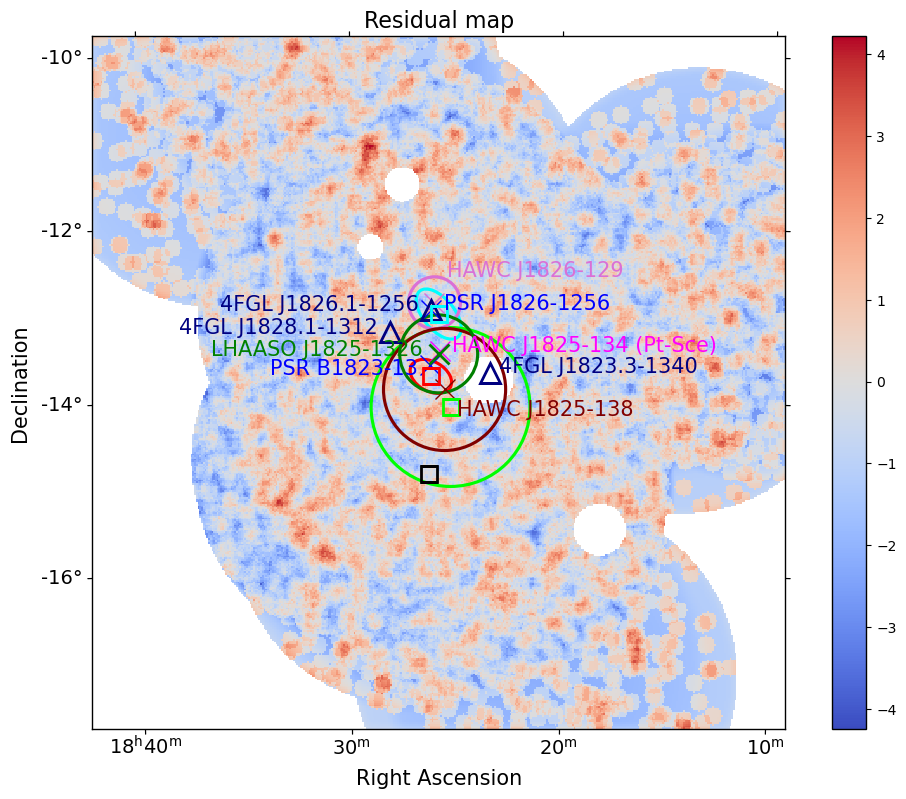

In [103]:
estimator = ExcessMapEstimator(
    correlation_radius=0.1 * u.deg,
    selection_optional=None,
    energy_edges=[lowE, highE] * u.TeV
    )
lima_maps_fit = estimator.run(stacked)


significance_map_fit = lima_maps_fit["sqrt_ts"]
sqrt_ts_image_fit = significance_map_fit.get_image_by_idx((0,))
#sqrt_ts_image_fit.write("sign_map_fits.fits")

fig = plt.figure(figsize=figsize)
fig.tight_layout()

ax = plt.subplot(111, projection=sqrt_ts_image_fit.geom.wcs)
#sqrt_ts_image_fit.plot(ax=ax, add_cbar=True, cmap='coolwarm')
#sqrt_ts_image_fit.smooth(width=0.5).plot(ax=ax, add_cbar=True, cmap='coolwarm')
sqrt_ts_image_fit.plot(ax=ax, add_cbar=True, cmap='coolwarm')

#Radio position of PSR J1826-1256
ax.plot(276.536 * u.deg, -12.943 * u.deg, color='blue', 
        fillstyle='none', marker="x", linestyle='dashed', 
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'), label='PSR J1826-1256')
ax.text(276.536-0.15, -12.943, 'PSR J1826-1256',
        transform=ax.get_transform("icrs"),
        color='blue', fontsize=plot_text_fontsize)

#Radio position of PSR B1823-13
ax.plot(276.554 * u.deg, -13.58 * u.deg, color='blue', 
        fillstyle='none', marker="x", linestyle='dashed', 
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'), label='PSR B1823-13')
ax.text(276.554+1.9, -13.58-0.1, 'PSR B1823-13',
        transform=ax.get_transform("icrs"),
        color='blue', fontsize=plot_text_fontsize)

#HAWC position of HAWC J1825-134
ax.plot(276.44 * u.deg, -13.42 * u.deg, color='magenta', 
        fillstyle='none', marker="x", linestyle='dashed', 
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'), label='HAWC J1825-134')
ax.text(276.44-0.15, -13.42, 'HAWC J1825-134 (Pt-Sce)',
        transform=ax.get_transform("icrs"),
        color='magenta', fontsize=plot_text_fontsize)
#HAWC position of HAWC J1825-138 (extended)
ax.plot(276.38 * u.deg, -13.86 * u.deg, color='maroon', 
        fillstyle='none', marker="x", linestyle='dashed', 
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'), label='HAWC J1825-138')
ax.text(276.38-0.15, -13.86-0.3, 'HAWC J1825-138',
        transform=ax.get_transform("icrs"),
        color='maroon', fontsize=plot_text_fontsize)
#HAWC position of HAWC J1826-129 (extended)
ax.plot(276.50 * u.deg, -12.86 * u.deg, color='orchid', 
        fillstyle='none', marker="x", linestyle='dashed', 
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'), label='HAWC J1826-129')
ax.text(276.5-0.15, -12.86+0.3, 'HAWC J1826-129',
        transform=ax.get_transform("icrs"),
        color='orchid', fontsize=plot_text_fontsize)

#LHAASO position of LHAASO J1825-1326
ax.plot(276.45 * u.deg, -13.45 * u.deg, color='green', 
        fillstyle='none', marker="x", linestyle='dashed', mew=mew, 
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'))
ax.text(276.45+2.7, -13.45, 'LHAASO J1825-1326',
        transform=ax.get_transform("icrs"),
        color='green', fontsize=plot_text_fontsize)

#Fermi 4FGL sources around HESS J1825-137
ax.plot(277.0276 * u.deg, -13.2019 * u.deg, color='navy', fillstyle='none', marker="^",  mew=mew,
        linewidth=lw, markersize=plot_markersize, transform=ax.get_transform('icrs'), label='4FGL J1828.1-1312')
ax.text(277.0276+2.5, -13.2019, '4FGL J1828.1-1312',
        transform=ax.get_transform("icrs"),
        color='navy', fontsize=plot_text_fontsize)
ax.plot(276.5352 * u.deg, -12.9415 * u.deg, color='navy', fillstyle='none', marker="^",  mew=mew,
        linewidth=lw, markersize=plot_markersize, transform=ax.get_transform('icrs'), label='4FGL J1826.1-1256')
ax.text(276.5352+2.5, -12.9415, '4FGL J1826.1-1256',
        transform=ax.get_transform("icrs"),
        color='navy', fontsize=plot_text_fontsize)
ax.plot(275.8363 * u.deg, -13.6676 * u.deg, color='navy', fillstyle='none', marker="^",  mew=mew,
        linewidth=lw, markersize=plot_markersize, transform=ax.get_transform('icrs'), label='4FGL J1823.3-1340')
ax.text(275.8363-0.1, -13.6676, '4FGL J1823.3-1340',
        transform=ax.get_transform("icrs"),
        color='navy', fontsize=plot_text_fontsize)


ax.plot(HESS_J1826_130_spatial_model.lon_0.value * u.deg, HESS_J1826_130_spatial_model.lat_0.value * u.deg, 
        color='cyan', fillstyle='none', marker="s", linestyle='dashed', mew=mew, 
        linewidth=lw, markersize=plot_markersize*0.8, 
        transform=ax.get_transform('icrs'))
HESS_J1826_130_region = HESS_J1826_130_spatial_model.to_region().to_pixel(ax.wcs)
HESS_J1826_130_artist = HESS_J1826_130_region.as_artist(facecolor="none", edgecolor="cyan", linewidth=1.5*lw)
ax.add_artist(HESS_J1826_130_artist)

ax.plot(HESS_J1825_137_peak_spatial_model.lon_0.value * u.deg, HESS_J1825_137_peak_spatial_model.lat_0.value * u.deg, 
        color='red', fillstyle='none', marker="s", linestyle='dashed', mew=mew, 
        linewidth=lw, markersize=plot_markersize*0.8, 
        transform=ax.get_transform('icrs'))
HESS_J1825_137_peak_region = HESS_J1825_137_peak_spatial_model.to_region().to_pixel(ax.wcs)
HESS_J1826_130_peak_artist = HESS_J1825_137_peak_region.as_artist(facecolor="none", edgecolor="red", linewidth=1.5*lw)
ax.add_artist(HESS_J1826_130_peak_artist)

ax.plot(HESS_J1825_137_halo_spatial_model.lon_0.value * u.deg, HESS_J1825_137_halo_spatial_model.lat_0.value * u.deg, 
        color='lime', fillstyle='none', marker="s", linestyle='dashed', mew=mew, 
        linewidth=lw, markersize=plot_markersize*0.8, 
        transform=ax.get_transform('icrs'))
HESS_J1825_137_halo_region = HESS_J1825_137_halo_spatial_model.to_region().to_pixel(ax.wcs)
HESS_J1826_130_halo_artist = HESS_J1825_137_halo_region.as_artist(facecolor="none", edgecolor="lime", linewidth=1.5*lw)
ax.add_artist(HESS_J1826_130_halo_artist)

ax.plot(LS5039_spatial_model.parameters["lon_0"].value * u.deg, LS5039_spatial_model.parameters["lat_0"].value * u.deg, 
        color='black', fillstyle='none', marker="s", linestyle='dashed', mew=mew, 
        linewidth=lw, markersize=plot_markersize*0.8, 
        transform=ax.get_transform('icrs'))

HAWC_J1826_128_region = HAWC_J1826_128_spatial_model.to_region().to_pixel(ax.wcs)
HAWC_J1826_128_artist = HAWC_J1826_128_region.as_artist(facecolor="none", edgecolor="orchid", linewidth=1.5*lw)
ax.add_artist(HAWC_J1826_128_artist)
HAWC_J1825_138_region = HAWC_J1825_138_spatial_model.to_region().to_pixel(ax.wcs)
HAWC_J1825_138_artist = HAWC_J1825_138_region.as_artist(facecolor="none", edgecolor="maroon", linewidth=1.5*lw)
ax.add_artist(HAWC_J1825_138_artist)
LHAASO_J1825_region = LHAASO_J1825_spatial_model.to_region().to_pixel(ax.wcs)
LHAASO_J1825_artist = LHAASO_J1825_region.as_artist(facecolor="none", edgecolor="green", linewidth=1.5*lw)
ax.add_artist(LHAASO_J1825_artist)

#ax.set_xlim(center-cut/2,center+cut/2)
#ax.set_ylim(center-cut/2,center+cut/2)

#legend_elements = [Line2D([0], [0], label=os.path.join('HESS J1826-130 ($\sigma$={}$^{}$)'.
#                                                       format(np.around(HESS_J1826_130_spatial_model.parameters["sigma"].value, 2), "\circ")), 
#                                                                      color='cyan', markersize=label_markersize),
#                  Line2D([0], [0], label=os.path.join('HESS J1825-137 core ($\sigma$={}$^{}$)'.
#                                                       format(np.around(HESS_J1825_137_peak_spatial_model.parameters["sigma"].value, 2), "\circ")), 
#                                                                      color='red', markersize=label_markersize),
#                  Line2D([0], [0], label=os.path.join('HESS J1825-137 diffuse ($\sigma$={}$^{}$)'.
#                                                       format(np.around(HESS_J1825_137_halo_spatial_model.parameters["sigma"].value, 2), "\circ")), 
#                                                                      color='lime', markersize=label_markersize),
#                  Line2D([0], [0], marker="s", color='none', label='[BDS2003] 8 -- Cluster of Stars',
#                          markeredgecolor='yellow', markersize=label_markersize)]
#ax.legend(handles=legend_elements, fancybox=True, framealpha=framealpha+0.2, loc = 'lower right', fontsize=lable_fontsize)
ax.set_title('Residual map', fontsize=title_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.set_xlabel('Right Ascension', fontsize=xylabel_fontsize)
ax.set_ylabel('Declination', fontsize=xylabel_fontsize)
#cbar.ax.tick_params(labelsize=xylabel_fontsize-1) 
plt.savefig(os.path.join(output,'residual_map.png'), dpi=dpi, bbox_inches='tight')
plt.show()

In [99]:
HESS_J1826_130_spatial_model.frame

'icrs'

### Residuals distribution

In [16]:
#1.3335214, 1.7782794, 2.3713737, 3.1622777, 4.216965, 5.6234133, 7.4989421, 10, 
#                  13.335214, 17.782794, 23.713737, 31.622777, 42.16965, 56.234133, 74.989421, 100

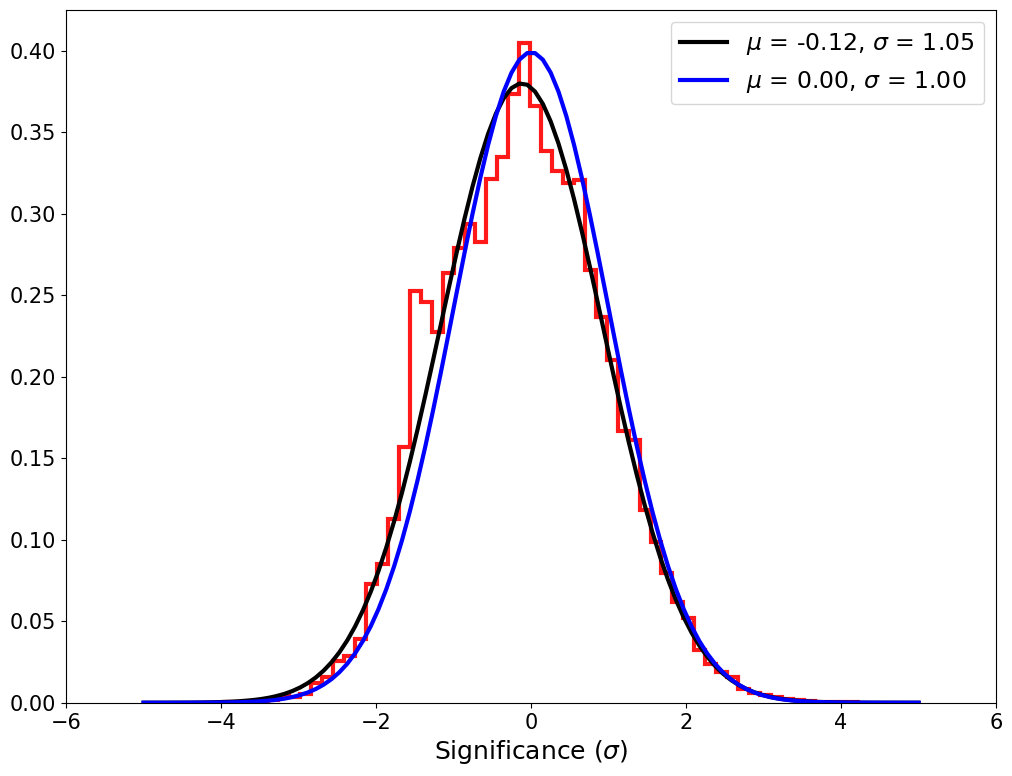

In [17]:
estimator = ExcessMapEstimator(
    correlation_radius=0.1 * u.deg,
    selection_optional=None,
    energy_edges=[lowE, highE] * u.TeV,
    )

lima_maps_fit = estimator.run(stacked)

significance_map_fit = lima_maps_fit["sqrt_ts"]
sqrt_ts_image_fit = significance_map_fit.get_image_by_idx((0,))

fig = plt.figure(figsize=figsize)
fig.tight_layout()

significance_data = sqrt_ts_image_fit.data
selection = np.isfinite(significance_data)
significance_data = significance_data[selection]
#significance_data = significance_data[significance_data != 0]
#significance_data = significance_data[abs(significance_data) > 0.009]

#plt.hist(significance_data, density=True, alpha=0.9, color="green", bins=60, linewidth=4)
plt.hist(significance_data, density=True, alpha=0.9, color="red", bins=60, histtype='step', linewidth=3)

mu, std = norm.fit(significance_data)

x = np.linspace(-5, 5, 100)
p = norm.pdf(x, mu, std)

plt.plot(
    x,
    p,
    lw=3,
    color="black",
    label=r"$\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(mu, std))

mu1, std1 = 0.0, 1.0
p1 = norm.pdf(x, mu1, std1)

plt.plot(
    x,
    p1,
    lw=3,
    color="blue",
    label=r"$\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(mu1, std1))


plt.legend(fontsize=lable_fontsize+5)
plt.xlim(-6, 6)

plt.tick_params(axis='both', which='major', labelsize=xylabel_fontsize)
plt.xlabel(r"Significance ($\sigma$)", fontsize=xylabel_fontsize+3)
#plt.ylabel(r"Probability", fontsize=xylabel_fontsize+3)
plt.savefig(os.path.join(output,'residuals_histogram.png'), dpi=dpi, bbox_inches='tight')
plt.show()

### Residual map in the energy bins

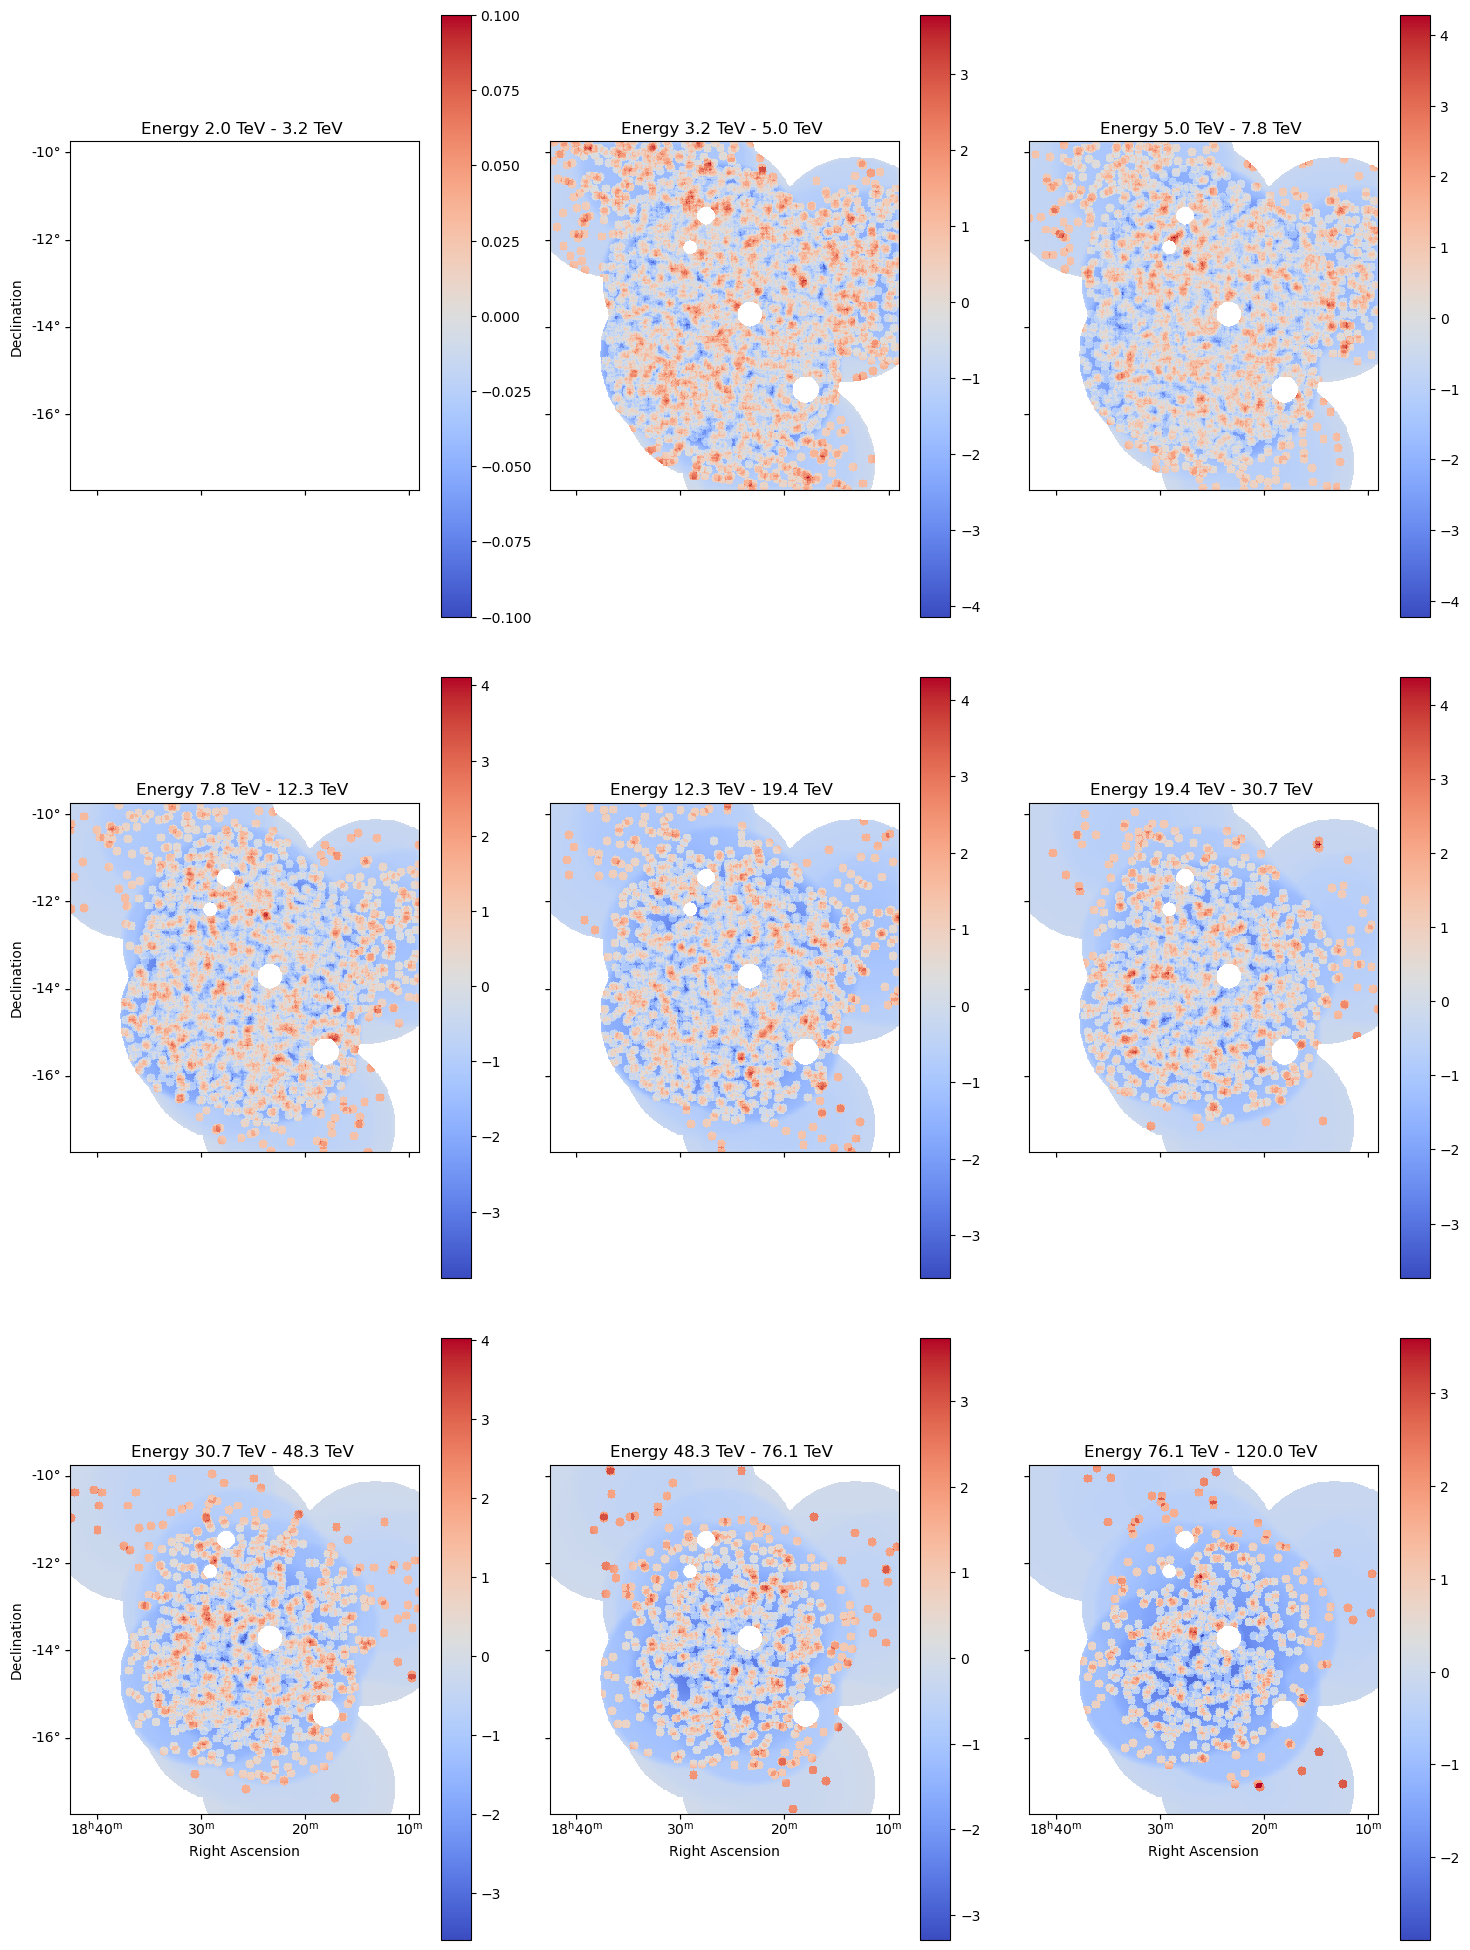

In [18]:
estimator = ExcessMapEstimator(
    correlation_radius=0.1 * u.deg,
    selection_optional=None,
    energy_edges=[1.3335214, 1.7782794, 2.3713737, 3.1622777, 4.216965, 5.6234133, 7.4989421, 10, 
                  13.335214, 17.782794, 23.713737, 31.622777, 42.16965, 56.234133, 74.989421, 100] * u.TeV,
    )
result = estimator.run(stacked)


result["sqrt_ts"].plot_grid(
    figsize=(18, 25), cmap="coolwarm", add_cbar=True)
plt.savefig(os.path.join(output,'residual_map_in_energy_bins.png'), dpi=dpi, bbox_inches='tight')
plt.show()

### Zoomed residual map

In [19]:
center_pos = SkyCoord(276.45, -13.78, unit="deg", frame="icrs")
sqrt_ts_image_fit_cut = sqrt_ts_image_fit.cutout(center_pos, width=[3*u.deg, 3*u.deg])

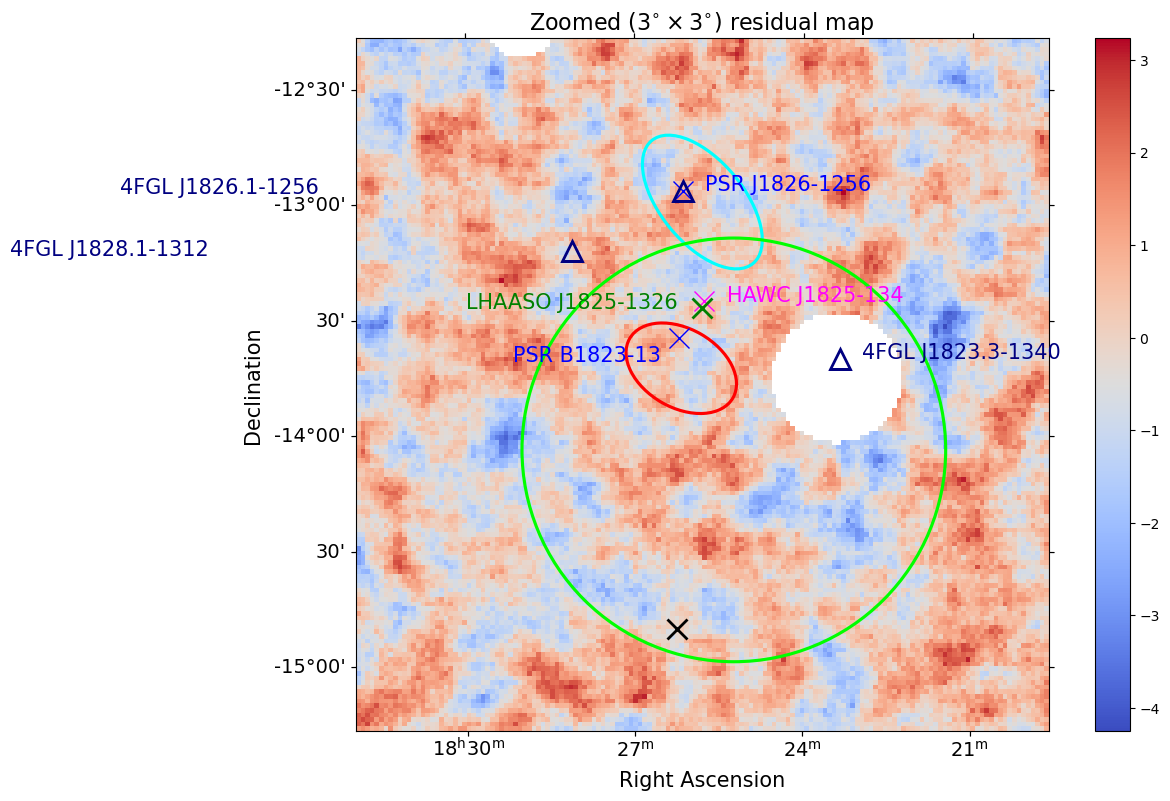

In [20]:
fig = plt.figure(figsize=figsize)
fig.tight_layout()

ax = plt.subplot(111, projection=sqrt_ts_image_fit_cut.geom.wcs)
#sqrt_ts_image_fit.plot(ax=ax, add_cbar=True, cmap='coolwarm')
#sqrt_ts_image_fit.smooth(width=0.5).plot(ax=ax, add_cbar=True, cmap='coolwarm')
sqrt_ts_image_fit_cut.plot(ax=ax, add_cbar=True, cmap='coolwarm')



#Radio position of PSR J1826-1256
ax.plot(276.536 * u.deg, -12.943 * u.deg, color='blue', 
        fillstyle='none', marker="x", linestyle='dashed', 
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'), label='PSR B1823-13')
ax.text(276.536-0.1, -12.943, 'PSR J1826-1256',
        transform=ax.get_transform("icrs"),
        color='blue', fontsize=plot_text_fontsize)

#Radio position of PSR B1823-13
ax.plot(276.554 * u.deg, -13.58 * u.deg, color='blue', 
        fillstyle='none', marker="x", linestyle='dashed', 
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'), label='PSR B1823-13')
ax.text(276.554+0.74, -13.58-0.1, 'PSR B1823-13',
        transform=ax.get_transform("icrs"),
        color='blue', fontsize=plot_text_fontsize)

#HAWC position of HAWC J1825-134
ax.plot(276.44 * u.deg, -13.42 * u.deg, color='magenta', 
        fillstyle='none', marker="x", linestyle='dashed', 
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'), label='HAWC J1825-134')
ax.text(276.44-0.1, -13.42, 'HAWC J1825-134',
        transform=ax.get_transform("icrs"),
        color='magenta', fontsize=plot_text_fontsize)

#LHAASO position of LHAASO J1825-1326
ax.plot(276.45 * u.deg, -13.45 * u.deg, color='green', 
        fillstyle='none', marker="x", linestyle='dashed', mew=mew, 
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'))
ax.text(276.45+1.05, -13.45, 'LHAASO J1825-1326',
        transform=ax.get_transform("icrs"),
        color='green', fontsize=plot_text_fontsize)

#Fermi 4FGL sources around HESS J1825-137
ax.plot(277.0276 * u.deg, -13.2019 * u.deg, color='navy', fillstyle='none', marker="^",  mew=mew,
        linewidth=lw, markersize=plot_markersize, transform=ax.get_transform('icrs'), label='4FGL J1828.1-1312')
ax.text(277.0276+2.5, -13.2019, '4FGL J1828.1-1312',
        transform=ax.get_transform("icrs"),
        color='navy', fontsize=plot_text_fontsize)
ax.plot(276.5352 * u.deg, -12.9415 * u.deg, color='navy', fillstyle='none', marker="^",  mew=mew,
        linewidth=lw, markersize=plot_markersize, transform=ax.get_transform('icrs'), label='4FGL J1826.1-1256')
ax.text(276.5352+2.5, -12.9415, '4FGL J1826.1-1256',
        transform=ax.get_transform("icrs"),
        color='navy', fontsize=plot_text_fontsize)
ax.plot(275.8363 * u.deg, -13.6676 * u.deg, color='navy', fillstyle='none', marker="^",  mew=mew,
        linewidth=lw, markersize=plot_markersize, transform=ax.get_transform('icrs'), label='4FGL J1823.3-1340')
ax.text(275.8363-0.1, -13.6676, '4FGL J1823.3-1340',
        transform=ax.get_transform("icrs"),
        color='navy', fontsize=plot_text_fontsize)

# [BDS2003] 8 -- Cluster of Stars
#ax.plot(18.1440 * u.deg, -0.2848 * u.deg, 
#        color='yellow', fillstyle='none', marker="s", 
#        linewidth=1, markersize=plot_markersize, transform=ax.get_transform('galactic'), 
#        label='[BDS2003] 8 - Cluster of Stars')


HESS_J1826_130_region = HESS_J1826_130_spatial_model.to_region().to_pixel(ax.wcs)
HESS_J1826_130_artist = HESS_J1826_130_region.as_artist(facecolor="none", edgecolor="cyan", linewidth=1.5*lw)
ax.add_artist(HESS_J1826_130_artist)

HESS_J1825_137_peak_region = HESS_J1825_137_peak_spatial_model.to_region().to_pixel(ax.wcs)
HESS_J1826_130_peak_artist = HESS_J1825_137_peak_region.as_artist(facecolor="none", edgecolor="red", linewidth=1.5*lw)
ax.add_artist(HESS_J1826_130_peak_artist)

HESS_J1825_137_halo_region = HESS_J1825_137_halo_spatial_model.to_region().to_pixel(ax.wcs)
HESS_J1826_130_halo_artist = HESS_J1825_137_halo_region.as_artist(facecolor="none", edgecolor="lime", linewidth=1.5*lw)
ax.add_artist(HESS_J1826_130_halo_artist)

ax.plot(LS5039_spatial_model.parameters["lon_0"].value * u.deg, LS5039_spatial_model.parameters["lat_0"].value * u.deg, 
        color='black', fillstyle='none', marker="x", linestyle='dashed', mew=mew, 
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'))

#ax.set_xlim(center-cut/2,center+cut/2)
#ax.set_ylim(center-cut/2,center+cut/2)

#legend_elements = [Line2D([0], [0], label=os.path.join('HESS J1826-130 ($\sigma$={}$^{}$)'.
#                                                       format(np.around(HESS_J1826_130_spatial_model.parameters["sigma"].value, 2), "\circ")), 
#                                                                      color='cyan', markersize=label_markersize),
#                  Line2D([0], [0], label=os.path.join('HESS J1825-137 core ($\sigma$={}$^{}$)'.
#                                                       format(np.around(HESS_J1825_137_peak_spatial_model.parameters["sigma"].value, 2), "\circ")), 
#                                                                      color='red', markersize=label_markersize),
#                  Line2D([0], [0], label=os.path.join('HESS J1825-137 diffuse ($\sigma$={}$^{}$)'.
#                                                       format(np.around(HESS_J1825_137_halo_spatial_model.parameters["sigma"].value, 2), "\circ")), 
#                                                                      color='lime', markersize=label_markersize),
#                  Line2D([0], [0], marker="s", color='none', label='[BDS2003] 8 -- Cluster of Stars',
#                          markeredgecolor='yellow', markersize=label_markersize)]
#ax.legend(handles=legend_elements, fancybox=True, framealpha=framealpha+0.2, loc = 'lower right', fontsize=lable_fontsize)
ax.set_title(r'Zoomed ($3^{\circ}\times3^{\circ}$) residual map', fontsize=title_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.set_xlabel('Right Ascension', fontsize=xylabel_fontsize)
ax.set_ylabel('Declination', fontsize=xylabel_fontsize)
plt.savefig(os.path.join(output,'zoomed_residual_map.png'), dpi=dpi, bbox_inches='tight')

# new_center_mask = SkyCoord(ra=275.95*u.deg, dec=-13.75*u.deg)
# new_radius_mask = 0.25*u.deg
# new_mask = CircleSkyRegion(center=new_center_mask, radius=new_radius_mask)
# new_mask_artist = new_mask.as_artist(facecolor="none", edgecolor="black", linewidth=1.5*lw)
# ax.add_artist(new_mask_artist)

plt.show()

### The best fitted models on top of the significance map

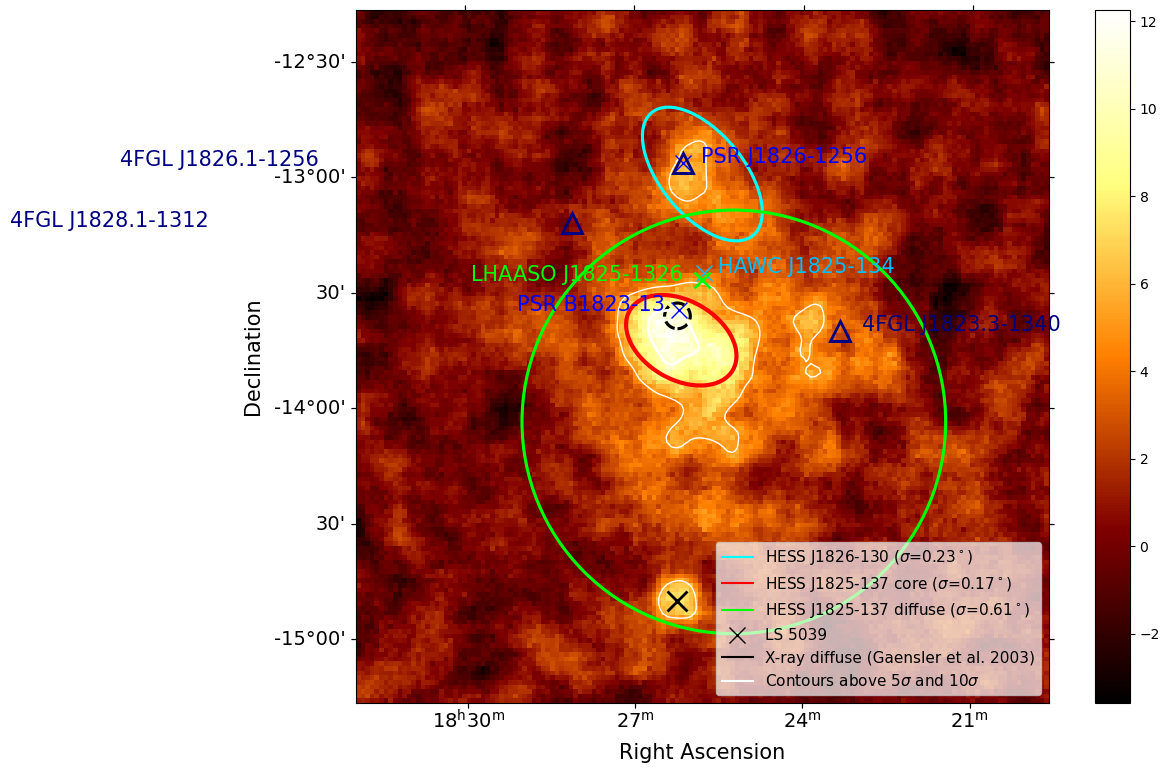

In [21]:
fig = plt.figure(figsize=figsize)
fig.tight_layout()

# ax = plt.subplot(111, projection=sqrt_ts_image.geom.wcs)
# sqrt_ts_image.plot(ax=ax, add_cbar=True)
sqrt_ts_image_cut = sqrt_ts_image.cutout(center_pos, width=[3*u.deg, 3*u.deg])
ax = plt.subplot(111, projection=sqrt_ts_image_cut.geom.wcs)
sqrt_ts_image_cut.plot(ax=ax, add_cbar=True)

plt.contour(sqrt_ts_image_cut.smooth(width=gaus_width).data,
           levels=[sigma_lvl1, sigma_lvl2], colors=['white'], linewidths=[1, 2])

#Radio position of PSR J1826-1256
ax.plot(276.536 * u.deg, -12.943 * u.deg, color='blue', 
        fillstyle='none', marker="x", linestyle='dashed', 
        linewidth=lw, markersize=plot_markersize-4, 
        transform=ax.get_transform('icrs'), label='PSR B1823-13')
ax.text(276.536-0.08, -12.943, 'PSR J1826-1256',
        transform=ax.get_transform("icrs"),
        color='blue', fontsize=plot_text_fontsize)

#Radio position of PSR B1823-13
ax.plot(276.554 * u.deg, -13.58 * u.deg, color='blue', 
        fillstyle='none', marker="x", linestyle='dashed', 
        linewidth=lw, markersize=plot_markersize-4, 
        transform=ax.get_transform('icrs'), label='PSR B1823-13')
ax.text(276.554+0.72, -13.58, 'PSR B1823-13',
        transform=ax.get_transform("icrs"),
        color='blue', fontsize=plot_text_fontsize)

#HAWC position of HAWC J1825-134
ax.plot(276.44 * u.deg, -13.42 * u.deg, color='deepskyblue', 
        fillstyle='none', marker="x", linestyle='dashed', 
        linewidth=lw, markersize=plot_markersize-4, 
        transform=ax.get_transform('icrs'), label='HAWC J1825-134')
ax.text(276.44-0.06, -13.42, 'HAWC J1825-134',
        transform=ax.get_transform("icrs"),
        color='deepskyblue', fontsize=plot_text_fontsize)

#LHAASO position of LHAASO J1825-1326
ax.plot(276.45 * u.deg, -13.45 * u.deg, color='lime', 
        fillstyle='none', marker="x", linestyle='dashed', mew=mew, 
        linewidth=lw, markersize=plot_markersize-4, 
        transform=ax.get_transform('icrs'))
ax.text(276.45+1.03, -13.45, 'LHAASO J1825-1326',
        transform=ax.get_transform("icrs"),
        color='lime', fontsize=plot_text_fontsize)

#Fermi 4FGL sources around HESS J1825-137
ax.plot(277.0276 * u.deg, -13.2019 * u.deg, color='navy', fillstyle='none', marker="^",  mew=mew,
        linewidth=lw, markersize=plot_markersize, transform=ax.get_transform('icrs'), label='4FGL J1828.1-1312')
ax.text(277.0276+2.5, -13.2019, '4FGL J1828.1-1312',
        transform=ax.get_transform("icrs"),
        color='navy', fontsize=plot_text_fontsize)
ax.plot(276.5352 * u.deg, -12.9415 * u.deg, color='navy', fillstyle='none', marker="^",  mew=mew,
        linewidth=lw, markersize=plot_markersize, transform=ax.get_transform('icrs'), label='4FGL J1826.1-1256')
ax.text(276.5352+2.5, -12.9415, '4FGL J1826.1-1256',
        transform=ax.get_transform("icrs"),
        color='navy', fontsize=plot_text_fontsize)
ax.plot(275.8363 * u.deg, -13.6676 * u.deg, color='navy', fillstyle='none', marker="^",  mew=mew,
        linewidth=lw, markersize=plot_markersize, transform=ax.get_transform('icrs'), label='4FGL J1823.3-1340')
ax.text(275.8363-0.1, -13.6676, '4FGL J1823.3-1340',
        transform=ax.get_transform("icrs"),
        color='navy', fontsize=plot_text_fontsize)


HESS_J1826_130_region = HESS_J1826_130_spatial_model.to_region().to_pixel(ax.wcs)
HESS_J1826_130_artist = HESS_J1826_130_region.as_artist(facecolor="none", edgecolor="cyan", linewidth=1.5*lw)
ax.add_artist(HESS_J1826_130_artist)

HESS_J1825_137_peak_region = HESS_J1825_137_peak_spatial_model.to_region().to_pixel(ax.wcs)
HESS_J1826_130_peak_artist = HESS_J1825_137_peak_region.as_artist(facecolor="none", edgecolor="red", linewidth=2*lw)
ax.add_artist(HESS_J1826_130_peak_artist)

HESS_J1825_137_halo_region = HESS_J1825_137_halo_spatial_model.to_region().to_pixel(ax.wcs)
HESS_J1826_130_halo_artist = HESS_J1825_137_halo_region.as_artist(facecolor="none", edgecolor="lime", linewidth=1.5*lw)
ax.add_artist(HESS_J1826_130_halo_artist)

ax.plot(LS5039_spatial_model.parameters["lon_0"].value * u.deg, LS5039_spatial_model.parameters["lat_0"].value * u.deg, 
        color='black', fillstyle='none', marker="x", linestyle='dashed', mew=mew, 
        linewidth=lw, markersize=plot_markersize, 
        transform=ax.get_transform('icrs'))


xmm_diffuse_component = DiskSpatialModel(
     lon_0=276.5599932*u.deg, lat_0=-13.60411689*u.deg, r_0=0.0555556*u.deg, frame="icrs")
xmm_diffuse_component = xmm_diffuse_component.to_region().to_pixel(ax.wcs)
xmm_diffuse_component = xmm_diffuse_component.as_artist(facecolor="none", 
                                                        edgecolor="k", linewidth=1.5*lw, linestyle='dashed')
ax.add_artist(xmm_diffuse_component)


# ax.set_xlim(center-cut/2,center+cut/2)
# ax.set_ylim(center-cut/2,center+cut/2)

legend_elements = [Line2D([0], [0], label=os.path.join('HESS J1826-130 ($\sigma$={}$^{}$)'.
                                                       format(np.around(HESS_J1826_130_spatial_model.parameters["sigma"].value, 2), "\circ")), 
                                                                      color='cyan', markersize=label_markersize),
                  Line2D([0], [0], label=os.path.join('HESS J1825-137 core ($\sigma$={}$^{}$)'.
                                                       format(np.around(HESS_J1825_137_peak_spatial_model.parameters["sigma"].value, 2), "\circ")), 
                                                                      color='red', markersize=label_markersize),
                  Line2D([0], [0], label=os.path.join('HESS J1825-137 diffuse ($\sigma$={}$^{}$)'.
                                                       format(np.around(HESS_J1825_137_halo_spatial_model.parameters["sigma"].value, 2), "\circ")), 
                                                                      color='lime', markersize=label_markersize),
                  Line2D([0], [0], label='LS 5039', marker="x", markeredgecolor='black', color='None', markersize=label_markersize),
                  Line2D([0], [0], label= 'X-ray diffuse (Gaensler et al. 2003)', color='k', markersize=label_markersize),                   
                  Line2D([0], [0], color='white', label=os.path.join('Contours above {}$\sigma$ and {}$\sigma$').
                          format(sigma_lvl1, sigma_lvl2),markeredgecolor='white', markersize=label_markersize)]

ax.legend(handles=legend_elements, fancybox=True, framealpha=framealpha, loc = 'lower right', fontsize=lable_fontsize-1)
#ax.set_title(os.path.join('Significance map with the best fitted models, ({}-{}) TeV'.format(lowE, highE)), fontsize=title_fontsize-1)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.set_xlabel('Right Ascension', fontsize=xylabel_fontsize)
ax.set_ylabel('Declination', fontsize=xylabel_fontsize)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=None)
plt.savefig(os.path.join(output,'sign_map_with_best_models.png'.
                        format(lowE, highE, threshold, min_distance, correlation_radius)), 
           dpi=dpi, bbox_inches='tight')
plt.show()

## Estimate of the flux points

### HESS J1826-130

In [22]:
path = Path(bridge_comp)

In [23]:
print(stacked.models)

DatasetModels

Component 0: SkyModel

  Name                      : HESS J1826-130
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      1.523   +/-    0.03             
    amplitude               :   1.15e-12   +/- 2.1e-13 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lambda_                 :      0.026   +/-    0.01 1 / TeV     
    alpha        (frozen)   :      1.000                   
    lon_0                   :    276.449   +/-    0.03 deg         
    lat_0                   :    -12.990   +/-    0.04 deg         
    sigma                   :      0.230   +/-    0.05 deg         
    e                       :      0.854   +/-    0.12             
    phi                     :     39.523   +/-   13.60 deg         

Component 1: SkyModel

  Name                      : LS 5

In [24]:
# ref_models.parameters.freeze_all()
# ref_models[0].parameters["amplitude"].frozen = False

ref_models[1].parameters.freeze_all()
ref_models[2].parameters.freeze_all()
ref_models[3].parameters.freeze_all()

#ref_models[0].parameters["index"].frozen = False
#ref_models[0].parameters["lambda_"].frozen = False
#ref_models[0].parameters["lon_0"].frozen = True
#ref_models[0].parameters["lat_0"].frozen = True
#ref_models[0].parameters["sigma"].frozen = True
#ref_models[0].parameters["e"].frozen = True
#ref_models[0].parameters["phi"].frozen = True

# n = 15
# energy_edges = np.logspace(np.log10(lowE),np.log10(highE),n+1) * u.TeV
energy_axis = MapAxis.from_energy_bounds(lowE, highE, per_decade=True, nbin=4, unit="TeV") # he
fpe_HESS_J1826_130=FluxPointsEstimator(energy_edges=energy_axis.edges, source="HESS J1826-130", 
                                       selection_optional="all", reoptimize=True)
flux_points_HESS_J1826_130 = fpe_HESS_J1826_130.run(datasets=stacked)
flux_points_HESS_J1826_130.meta['sqrt_ts_threshold_ul'] = 2
# flux_points_HESS_J1826_130.table["is_ul"] = flux_points_HESS_J1826_130.table["ts"] < 4.0
# data_HESS_J1826_130 = flux_points_HESS_J1826_130.table_formatted[
#     'counts','e_ref','e_min','e_max','dnde','dnde_err','sqrt_ts']
data_HESS_J1826_130 = flux_points_HESS_J1826_130.to_table(sed_type="dnde", formatted=True)
print(data_HESS_J1826_130)

Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.44912415, -12.99007423)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.56349766, -14.83782155)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.54299489, -13.70960784)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.30859851, -14.06301119)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.44912415, -12.99007423)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.56349766, -14.83782155)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.54299489, -13.70960784)> is outside valid IRF map range, using nearest IRF defined within

e_ref  e_min   e_max        dnde      ...    stat   is_ul counts [1] success
 TeV    TeV     TeV   1 / (cm2 s TeV) ...                                   
------ ------ ------- --------------- ... --------- ----- ---------- -------
 2.511  2.000   3.152             nan ...     0.000  True        0.0   False
 3.957  3.152   4.968       2.007e-13 ... 62559.669 False    10892.0    True
 6.237  4.968   7.830       1.163e-13 ... 48732.436 False     7630.0    True
 9.830  7.830  12.340       2.345e-14 ... 36375.105 False     5082.0    True
15.492 12.340  19.449             nan ... 27289.331  True     3439.0   False
24.416 19.449  30.652       2.776e-15 ... 19566.424 False     2260.0    True
38.481 30.652  48.310       2.951e-15 ... 14834.358 False     1591.0    True
60.649 48.310  76.139       8.704e-16 ... 11012.441 False     1092.0    True
95.586 76.139 120.000       8.040e-15 ...  8090.266 False      757.0    True


None zQuKc-7F
OK flux_points


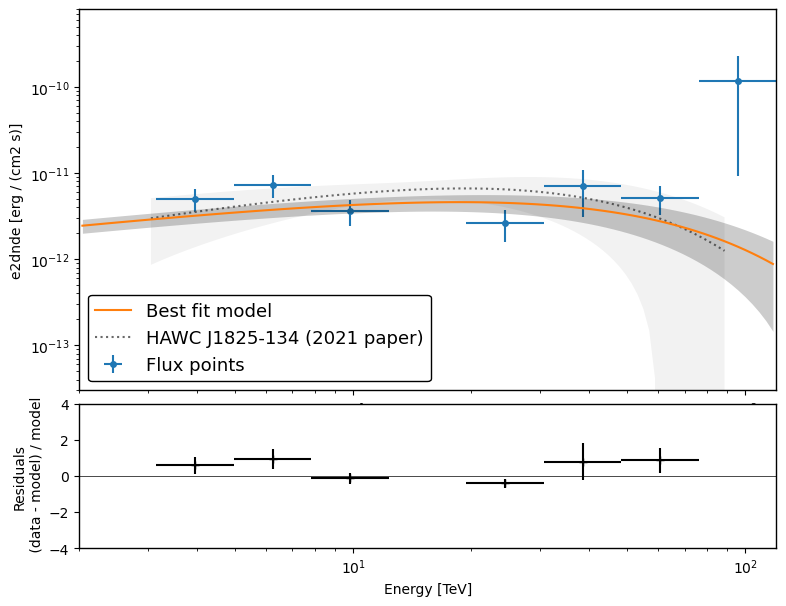

In [66]:
HESS_J1826_130_model.parameters["amplitude"].frozen = False
HESS_J1826_130_model.parameters["index"].frozen = False
HESS_J1826_130_model.parameters["lambda_"].frozen = False

flux_points_dataset_HESS_J1826_130 = FluxPointsDataset(
    data=flux_points_HESS_J1826_130, models=HESS_J1826_130_model)
ax1,ax2 = flux_points_dataset_HESS_J1826_130.plot_fit()
ax1.set_ylim([3e-14, 8e-10])
ax2.set_ylim([-4, 4])

# J1825 HAWC (2021) - 0.47
#https://iopscience.iop.org/article/10.3847/2041-8213/abd77b/pdf - 1.200TeV
HAWC_J1826_128 = ExpCutoffPowerLawSpectralModel(  #0.20+/-0.03 deg
    amplitude = "2.7e-14 TeV-1 cm-2 s-1",
    index = 1.2,
    lambda_ = 0.0417 * u.Unit("TeV-1"),
    reference = "18 TeV",
)
HAWC_J1826_128.parameters['index'].error = 0.4
HAWC_J1826_128.parameters['amplitude'].error = 0.95e-15 * u.Unit("cm-2 s-1 TeV-1")
HAWC_J1826_128.parameters['lambda_'].error = 0.0147 * u.Unit("TeV-1")
HAWC_J1826_128.plot(energy_bounds=[3.0, 90] * u.TeV, sed_type="e2dnde", color='dimgray', linestyle='dotted', 
                          label = "HAWC J1825-134 (2021 paper)", ax=ax1)
HAWC_J1826_128.plot_error(energy_bounds=[3.0, 90.] * u.TeV, sed_type="e2dnde", color='dimgray', 
                                linestyle='dotted', alpha=alpha, ax=ax1)

ax1.legend(fancybox=True, framealpha=1, loc = 'lower left', fontsize=13, edgecolor='black')

flux_points_dataset_HESS_J1826_130.write(path / "flux_points_HESS_J1826_130_with_3d_he.fits", overwrite=True)
# plt.savefig("flux_points_dataset_HESS_J1826_130.png")
plt.show()

In [75]:
flux_points_HESS_J1826_130.meta

{'n_sigma': 1,
 'n_sigma_ul': 2,
 'sed_type_init': 'likelihood',
 'SED_TYPE': 'likelihood'}

In [26]:
# stacked.psf.mask_safe_image.plot();
# plt.savefig("psf_mask.png")
# plt.show()

### HESS J1825-137 peak

In [27]:
# ref_models.parameters.freeze_all()
# ref_models[2].parameters["amplitude"].frozen = False
#ref_models[2].parameters["index"].frozen = False
#ref_models[2].parameters["lambda_"].frozen = False
#ref_models[2].parameters["lon_0"].frozen = True
#ref_models[2].parameters["lat_0"].frozen = True
#ref_models[2].parameters["sigma"].frozen = True
#ref_models[2].parameters["e"].frozen = True
#ref_models[2].parameters["phi"].frozen = True

ref_models[0].parameters.freeze_all()
ref_models[1].parameters.freeze_all()
ref_models[3].parameters.freeze_all()

# n = 15
# energy_edges = np.logspace(np.log10(lowE),np.log10(highE),n+1) * u.TeV
energy_axis = MapAxis.from_energy_bounds(lowE, highE, per_decade=True, nbin=5, unit="TeV") # he
fpe_HESS_J1825_137_peak=FluxPointsEstimator(energy_edges=energy_axis.edges, 
                                            source="HESS J1825-137 peak", selection_optional="all", reoptimize=True)
flux_points_HESS_J1825_137_peak = fpe_HESS_J1825_137_peak.run(stacked)
flux_points_HESS_J1825_137_peak.meta['sqrt_ts_threshold_ul'] = 2

# flux_points_HESS_J1825_137_peak.table["is_ul"] = flux_points_HESS_J1825_137_peak.table["ts"] < 4
# data_HESS_J1825_137_peak = flux_points_HESS_J1825_137_peak.table_formatted[
#     'counts','e_ref','e_min','e_max','dnde','dnde_err','sqrt_ts']
data_HESS_J1825_137_peak = flux_points_HESS_J1825_137_peak.to_table(sed_type="dnde", formatted=True)
print(data_HESS_J1825_137_peak)

Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.44912415, -12.99007423)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.56349766, -14.83782155)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.54299489, -13.70960784)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.30859851, -14.06301119)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.44912415, -12.99007423)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.56349766, -14.83782155)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.54299489, -13.70960784)> is outside valid IRF map range, using nearest IRF defined within

e_ref  e_min   e_max        dnde      ...    stat   is_ul counts [1] success
 TeV    TeV     TeV   1 / (cm2 s TeV) ...                                   
------ ------ ------- --------------- ... --------- ----- ---------- -------
 2.511  2.000   3.152             nan ...     0.000  True        0.0   False
 3.957  3.152   4.968       2.646e-13 ... 62571.481 False    10892.0    True
 6.237  4.968   7.830       9.874e-14 ... 48741.505 False     7630.0    True
 9.830  7.830  12.340       3.837e-14 ... 36379.779 False     5082.0    True
15.492 12.340  19.449       1.246e-14 ... 27308.548 False     3439.0    True
24.416 19.449  30.652       6.771e-15 ... 19571.169 False     2260.0    True
38.481 30.652  48.310       1.729e-15 ... 14840.922 False     1591.0    True
60.649 48.310  76.139       1.228e-15 ... 11021.335 False     1092.0    True
95.586 76.139 120.000       8.701e-16 ...  8104.179 False      757.0    True


None WMMmDWeB
OK flux_points


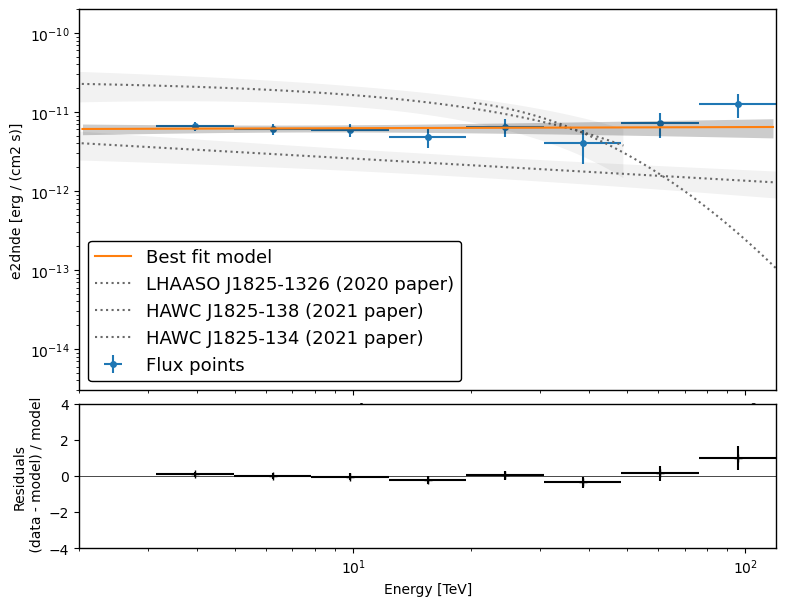

In [63]:
HESS_J1825_137_peak_model.parameters["amplitude"].frozen = False
HESS_J1825_137_peak_model.parameters["index"].frozen = False
HESS_J1825_137_peak_model.parameters["lambda_"].frozen = True
flux_points_dataset_HESS_J1825_137_peak = FluxPointsDataset(
    data=flux_points_HESS_J1825_137_peak, models=HESS_J1825_137_peak_model)
ax1,ax2 = flux_points_dataset_HESS_J1825_137_peak.plot_fit()
ax1.set_ylim([3e-15, 2e-10])
ax2.set_ylim([-4, 4])

# # J1825 LHAASO (2020) - 0.30 ± 0.06 20-500TeV
from gammapy.modeling.models import LogParabolaSpectralModel
LHAASO_J1825 = LogParabolaSpectralModel(
    amplitude = "6.875e-14 TeV-1 cm-2 s-1", # 1.1e-11 erg cm-2 s-1 @10TeV -> 1.1e-11/(1.6*10)/10=6.875e-14
    alpha = 0.92,
    beta = 1.19,
    reference = "10 TeV",
)
LHAASO_J1825.plot(energy_bounds=[20., 500] * u.TeV, sed_type="e2dnde", color='dimgray', linestyle='dotted', 
                          label = "LHAASO J1825-1326 (2020 paper)", ax=ax1)

# J1825 HAWC (2021) - 0.47
#https://iopscience.iop.org/article/10.3847/2041-8213/abd77b/pdf - 1.200TeV
HAWC_J1825_138 = ExpCutoffPowerLawSpectralModel(  #0.47+/-0.04 deg - 0.5/50
    amplitude = "4.5e-14 TeV-1 cm-2 s-1",
    index = 2.02,
    lambda_ = 0.0370 * u.Unit("TeV-1"),
    reference = "18 TeV",
)
HAWC_J1825_138.parameters['index'].error = 0.15
HAWC_J1825_138.parameters['amplitude'].error = 1.15e-14 * u.Unit("cm-2 s-1 TeV-1")
HAWC_J1825_138.parameters['lambda_'].error = 0.011 * u.Unit("TeV-1")
HAWC_J1825_138.plot(energy_bounds=[0.5, 50] * u.TeV, sed_type="e2dnde", color='dimgray', linestyle='dotted', 
                          label = "HAWC J1825-138 (2021 paper)", ax=ax1)
HAWC_J1825_138.plot_error(energy_bounds=[0.5, 50.] * u.TeV, sed_type="e2dnde", color='dimgray', 
                                linestyle='dotted', alpha=alpha, ax=ax1)

HAWC_J1825_134 = PowerLawSpectralModel(   #YSC? Point Source, associated with  HESS J1825-137 
    amplitude = "4.2e-15 TeV-1 cm-2 s-1",
    index = 2.28,
    reference = "18 TeV",
)
HAWC_J1825_134.parameters['index'].error = 0.12
HAWC_J1825_134.parameters['amplitude'].error = 1.25e-15 * u.Unit("cm-2 s-1 TeV-1")
HAWC_J1825_134.plot(energy_bounds=[0.7, 300] * u.TeV, sed_type="e2dnde", color='dimgray', linestyle='dotted', 
                          label = "HAWC J1825-134 (2021 paper)", ax=ax1)
HAWC_J1825_134.plot_error(energy_bounds=[0.7, 300.] * u.TeV, sed_type="e2dnde", color='dimgray', 
                                linestyle='dotted', alpha=alpha, ax=ax1)

ax1.legend(fancybox=True, framealpha=1, loc = 'lower left', fontsize=13, edgecolor='black')

flux_points_dataset_HESS_J1825_137_peak.write(path / "flux_points_HESS_J1825_137_peak_with_3d_he.fits", overwrite=True)
# plt.savefig("flux_points_dataset_HESS_J1825_137_peak.png")
plt.show()

### HESS J1825-137 halo

In [29]:
# ref_models.parameters.freeze_all()
# ref_models[3].parameters["amplitude"].frozen = False
#ref_models[3].parameters["index"].frozen = True
#ref_models[3].parameters["lambda_"].frozen = True
#ref_models[3].parameters["lon_0"].frozen = True
#ref_models[3].parameters["lat_0"].frozen = True
#ref_models[3].parameters["sigma"].frozen = True
#ref_models[3].parameters["e"].frozen = True
#ref_models[3].parameters["phi"].frozen = True

ref_models[0].parameters.freeze_all()
ref_models[1].parameters.freeze_all()
ref_models[2].parameters.freeze_all()

# n = 15
# energy_edges = np.logspace(np.log10(lowE),np.log10(highE),n+1) * u.TeV
energy_axis = MapAxis.from_energy_bounds(lowE, highE, per_decade=True, nbin=5, unit="TeV") # he
fpe_HESS_J1825_137_halo=FluxPointsEstimator(energy_edges=energy_axis.edges, 
                                            source="HESS J1825-137 halo", selection_optional="all", reoptimize=True)
flux_points_HESS_J1825_137_halo = fpe_HESS_J1825_137_halo.run(stacked)
flux_points_HESS_J1825_137_halo.meta['sqrt_ts_threshold_ul'] = 2

# flux_points_HESS_J1825_137_halo.table["is_ul"] = flux_points_HESS_J1825_137_halo.table["ts"] < 4
# data_HESS_J1825_137_halo = flux_points_HESS_J1825_137_halo.table_formatted[
#     'counts','e_ref','e_min','e_max','dnde','dnde_err','sqrt_ts']
data_HESS_J1825_137_halo = flux_points_HESS_J1825_137_halo.to_table(sed_type="dnde", formatted=True)
print(data_HESS_J1825_137_halo)

Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.44912415, -12.99007423)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.56349766, -14.83782155)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.54299489, -13.70960784)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.30859851, -14.06301119)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.44912415, -12.99007423)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.56349766, -14.83782155)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.54299489, -13.70960784)> is outside valid IRF map range, using nearest IRF defined within

e_ref  e_min   e_max        dnde      ...    stat   is_ul counts [1] success
 TeV    TeV     TeV   1 / (cm2 s TeV) ...                                   
------ ------ ------- --------------- ... --------- ----- ---------- -------
 2.511  2.000   3.152             nan ...     0.000  True        0.0   False
 3.957  3.152   4.968       1.337e-12 ... 62568.576 False    10892.0    True
 6.237  4.968   7.830       4.670e-13 ... 48741.382 False     7630.0    True
 9.830  7.830  12.340       1.561e-13 ... 36379.369 False     5082.0    True
15.492 12.340  19.449       4.908e-14 ... 27307.944 False     3439.0    True
24.416 19.449  30.652       1.780e-14 ... 19570.235 False     2260.0    True
38.481 30.652  48.310       4.229e-15 ... 14840.733 False     1591.0    True
60.649 48.310  76.139       6.428e-16 ... 11020.199 False     1092.0    True
95.586 76.139 120.000       1.247e-15 ...  8105.704 False      757.0    True


None HESS J18250-137 halo
OK flux_points


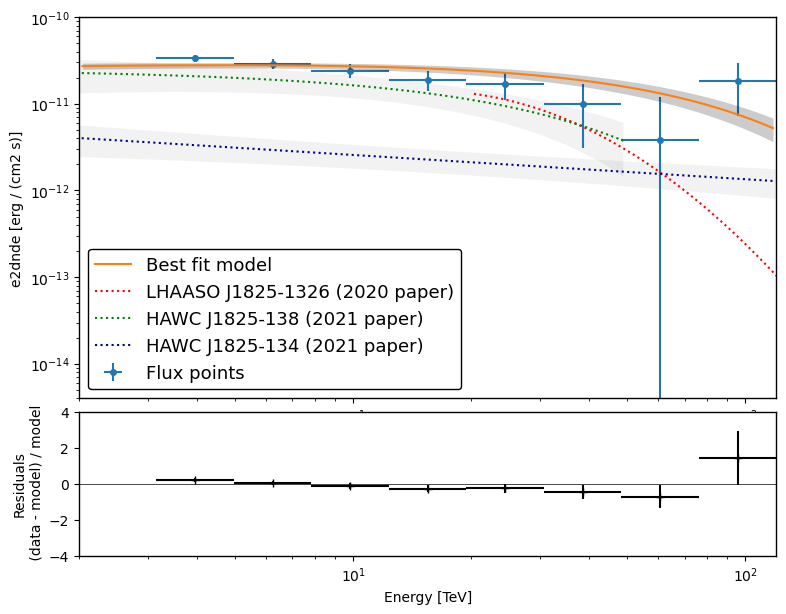

In [61]:
HESS_J1825_137_halo_model.parameters["amplitude"].frozen = False
HESS_J1825_137_halo_model.parameters["index"].frozen = False
HESS_J1825_137_halo_model.parameters["lambda_"].frozen = False
flux_points_dataset_HESS_J1825_137_halo = FluxPointsDataset(
    data=flux_points_HESS_J1825_137_halo, models=HESS_J1825_137_halo_model, name="HESS J18250-137 halo")
ax1,ax2 = flux_points_dataset_HESS_J1825_137_halo.plot_fit()
ax1.set_ylim([4e-15, 1e-10])
ax2.set_ylim([-4, 4])

# J1825 LHAASO (2020) - 0.30 ± 0.06 20-500TeV
from gammapy.modeling.models import LogParabolaSpectralModel
LHAASO_J1825 = LogParabolaSpectralModel(
    amplitude = "6.875e-14 TeV-1 cm-2 s-1", # 1.1e-11 erg cm-2 s-1 @10TeV -> 1.1e-11/(1.6*10)/10=6.875e-14
    alpha = 0.92,
    beta = 1.19,
    reference = "10 TeV",
)
LHAASO_J1825.plot(energy_bounds=[20., 500] * u.TeV, sed_type="e2dnde", color='red', linestyle='dotted', 
                          label = "LHAASO J1825-1326 (2020 paper)", ax=ax1)

# J1825 HAWC (2021) - 0.47
#https://iopscience.iop.org/article/10.3847/2041-8213/abd77b/pdf - 1.200TeV
HAWC_J1825_138 = ExpCutoffPowerLawSpectralModel(  #0.47+/-0.04 deg - 0.5/50
    amplitude = "4.5e-14 TeV-1 cm-2 s-1",
    index = 2.02,
    lambda_ = 0.0370 * u.Unit("TeV-1"),
    reference = "18 TeV",
)
HAWC_J1825_138.parameters['index'].error = 0.15
HAWC_J1825_138.parameters['amplitude'].error = 1.15e-14 * u.Unit("cm-2 s-1 TeV-1")
HAWC_J1825_138.parameters['lambda_'].error = 0.011 * u.Unit("TeV-1")
HAWC_J1825_138.plot(energy_bounds=[0.5, 50] * u.TeV, sed_type="e2dnde", color='green', linestyle='dotted', 
                          label = "HAWC J1825-138 (2021 paper)", ax=ax1)
HAWC_J1825_138.plot_error(energy_bounds=[0.5, 50.] * u.TeV, sed_type="e2dnde", color='green', 
                                linestyle='dotted', alpha=alpha, ax=ax1)

HAWC_J1825_134 = PowerLawSpectralModel(   #YSC? Point Source, associated with  HESS J1825-137 
    amplitude = "4.2e-15 TeV-1 cm-2 s-1",
    index = 2.28,
    reference = "18 TeV",
)
HAWC_J1825_134.parameters['index'].error = 0.12
HAWC_J1825_134.parameters['amplitude'].error = 1.25e-15 * u.Unit("cm-2 s-1 TeV-1")
HAWC_J1825_134.plot(energy_bounds=[0.7, 300] * u.TeV, sed_type="e2dnde", color='darkblue', linestyle='dotted', 
                          label = "HAWC J1825-134 (2021 paper)", ax=ax1)
HAWC_J1825_134.plot_error(energy_bounds=[0.7, 300.] * u.TeV, sed_type="e2dnde", color='darkblue', 
                                linestyle='dotted', alpha=alpha, ax=ax1)
ax1.legend(fancybox=True, framealpha=1, loc = 'lower left', fontsize=13, edgecolor='black')

flux_points_dataset_HESS_J1825_137_halo.write(path / "flux_points_HESS_J1825_137_halo_with_3d_he.fits", overwrite=True)
# plt.savefig("flux_points_dataset_HESS_J1825_137_halo.png")
plt.show()

### LS 5039

In [31]:
# ref_models.parameters.freeze_all()
# ref_models[1].parameters["amplitude"].frozen = False
#ref_models[1].parameters["index"].frozen = False
#ref_models[1].parameters["lambda_"].frozen = False
#ref_models[1].parameters["lon_0"].frozen = True
#ref_models[1].parameters["lat_0"].frozen = True
#ref_models[1].parameters["sigma"].frozen = True
#ref_models[1].parameters["e"].frozen = True
#ref_models[1].parameters["phi"].frozen = True

ref_models[0].parameters.freeze_all()
ref_models[2].parameters.freeze_all()
ref_models[3].parameters.freeze_all()

# n = 13
# energy_edges = np.logspace(np.log10(lowE),np.log10(highE),n+1) * u.TeV
# fpe_LS5039=FluxPointsEstimator(energy_edges=energy_edges, source="LS 5039", reoptimize=True)
energy_axis = MapAxis.from_energy_bounds(lowE, highE, per_decade=True, nbin=5, unit="TeV") # he
fpe_LS5039=FluxPointsEstimator(energy_edges=energy_axis.edges, source="LS 5039", 
                               selection_optional="all", reoptimize=True)
flux_points_LS5039 = fpe_LS5039.run(stacked)
flux_points_LS5039.meta['sqrt_ts_threshold_ul'] = 2

# flux_points_LS5039.table["is_ul"] = flux_points_LS5039.table["ts"] < 4.0
# data_LS5039 = flux_points_LS5039.table_formatted[
#     'counts','e_ref','e_min','e_max','dnde','dnde_err','sqrt_ts']
data_LS5039 = flux_points_LS5039.to_table(sed_type="dnde", formatted=True)
print(data_LS5039)

Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.44912415, -12.99007423)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.56349766, -14.83782155)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.54299489, -13.70960784)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.30859851, -14.06301119)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.44912415, -12.99007423)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.56349766, -14.83782155)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (276.54299489, -13.70960784)> is outside valid IRF map range, using nearest IRF defined within

e_ref  e_min   e_max        dnde      ...    stat   is_ul counts [1] success
 TeV    TeV     TeV   1 / (cm2 s TeV) ...                                   
------ ------ ------- --------------- ... --------- ----- ---------- -------
 2.511  2.000   3.152             nan ...     0.000  True        0.0   False
 3.957  3.152   4.968       6.231e-14 ... 62571.709 False    10892.0    True
 6.237  4.968   7.830       3.379e-14 ... 48739.419 False     7630.0    True
 9.830  7.830  12.340       3.903e-15 ... 36378.547 False     5082.0    True
15.492 12.340  19.449       2.730e-15 ... 27309.675 False     3439.0    True
24.416 19.449  30.652       9.686e-16 ... 19571.110 False     2260.0    True
38.481 30.652  48.310       1.344e-19 ... 14839.215 False     1591.0    True
60.649 48.310  76.139       1.460e-16 ... 11021.235 False     1092.0    True
95.586 76.139 120.000       1.153e-16 ...  8105.634 False      757.0    True


None KXuM1f1p
OK flux_points


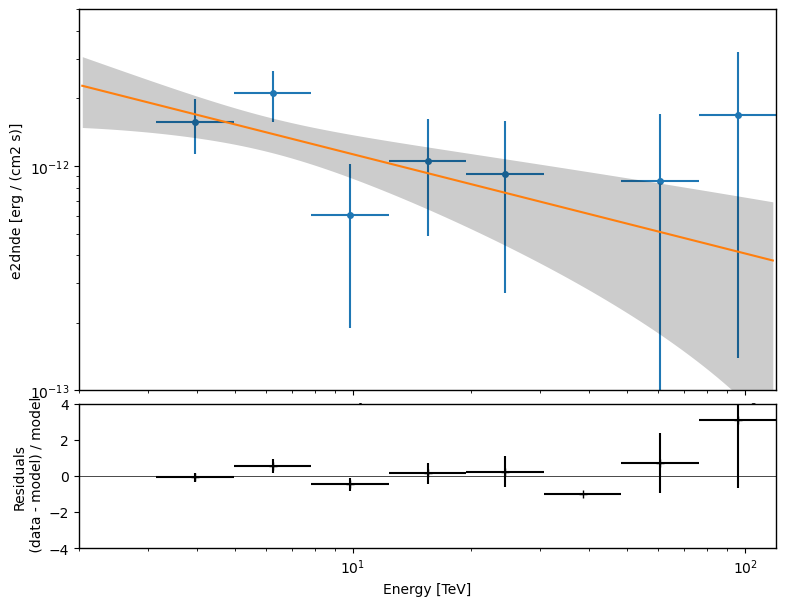

In [49]:
LS5039_model.parameters["amplitude"].frozen = False
LS5039_model.parameters["index"].frozen = False
LS5039_model.parameters["lambda_"].frozen = True
flux_points_dataset_LS5039 = FluxPointsDataset(
    data=flux_points_LS5039, models=LS5039_model)
ax1,ax2 = flux_points_dataset_LS5039.plot_fit()
ax1.set_ylim([1e-13, 5e-12])
ax2.set_ylim([-4, 4])

flux_points_dataset_LS5039.write(path / "flux_points_LS5039_with_3d_he.fits", overwrite=True)
# plt.savefig("flux_points_dataset_LS5039.png")
plt.show()

### Joint plot

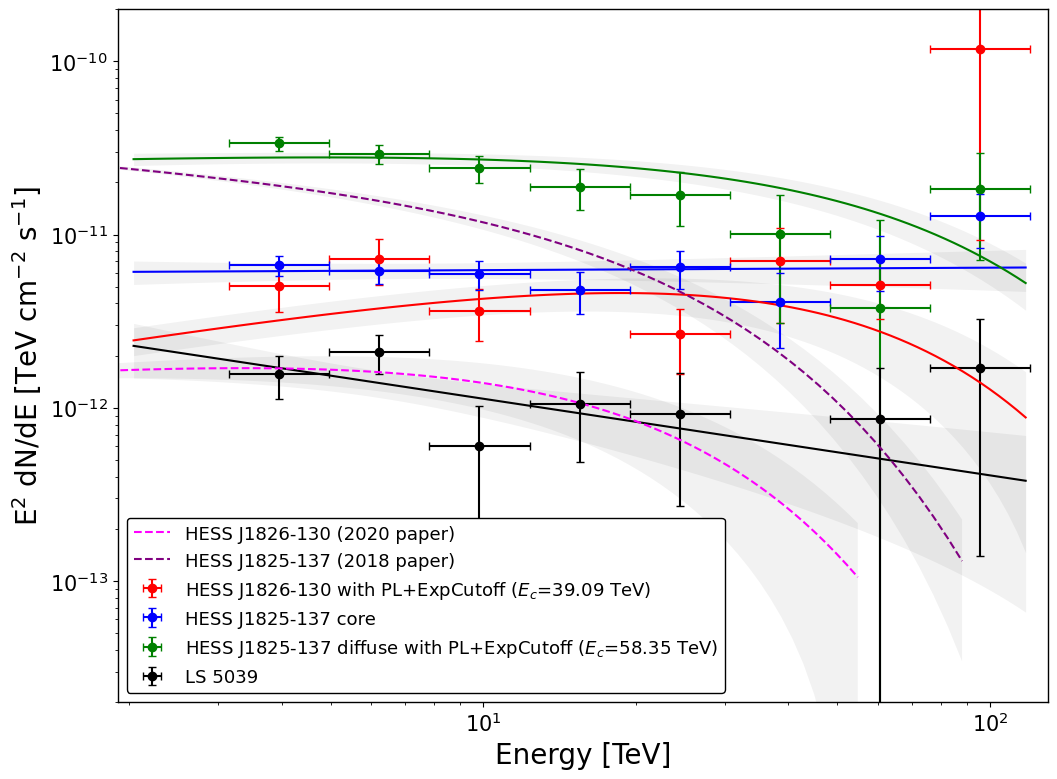

In [52]:
HESS_J1825_137_peak_model.parameters["amplitude"].frozen = False
HESS_J1825_137_peak_model.parameters["index"].frozen = False
HESS_J1825_137_peak_model.parameters["lambda_"].frozen = True
HESS_J1825_137_halo_model.parameters["amplitude"].frozen = False
HESS_J1825_137_halo_model.parameters["index"].frozen = False
HESS_J1825_137_halo_model.parameters["lambda_"].frozen = False
LS5039_model.parameters["amplitude"].frozen = False
LS5039_model.parameters["index"].frozen = False
LS5039_model.parameters["lambda_"].frozen = True
HESS_J1826_130_model.parameters["amplitude"].frozen = False
HESS_J1826_130_model.parameters["index"].frozen = False
HESS_J1826_130_model.parameters["lambda_"].frozen = False

fig = plt.figure(figsize=(12,9))
fig.tight_layout()

capsize, alpha, markersize = 3, 0.05, 6
flux_unit = 'cm-2 s-1 TeV-1'
energy_range = [lowE, highE]

mylabel = "HESS J1826-130"
if HESS_J1826_130_model.parameters["lambda_"].value>0:
    mylabel += " with PL+ExpCutoff ($E_c$={} TeV)".format(np.around(1./HESS_J1826_130_model.parameters["lambda_"].value, 2))
ax = flux_points_HESS_J1826_130.plot(sed_type="e2dnde", color='red', capsize=capsize, marker='o', markersize=markersize, 
                                label = mylabel)     
HESS_J1826_130_spectral_model.plot(energy_bounds=energy_range * u.TeV, sed_type="e2dnde", color='red', ax=ax)
HESS_J1826_130_spectral_model.plot_error(energy_bounds=energy_range * u.TeV, sed_type="e2dnde", color='red', alpha=alpha, ax=ax)

mylabel = "HESS J1825-137 core"
if HESS_J1825_137_peak_model.parameters["lambda_"].value>0:
    mylabel += " with PL+ExpCutoff ($E_c$={} TeV)".format(np.around(1./HESS_J1825_137_peak_model.parameters["lambda_"].value, 2))
flux_points_HESS_J1825_137_peak.plot(sed_type="e2dnde", color='blue', capsize=capsize, marker='o', 
                                     markersize=markersize, label = mylabel)
HESS_J1825_137_peak_spectral_model.plot(energy_bounds=energy_range * u.TeV, sed_type="e2dnde", color='blue')
HESS_J1825_137_peak_spectral_model.plot_error(energy_bounds=energy_range * u.TeV, sed_type="e2dnde", color='blue', alpha=alpha)


mylabel = "HESS J1825-137 diffuse"
if HESS_J1825_137_halo_model.parameters["lambda_"].value>0:
    mylabel += " with PL+ExpCutoff ($E_c$={} TeV)".format(np.around(1./HESS_J1825_137_halo_model.parameters["lambda_"].value, 2))
flux_points_HESS_J1825_137_halo.plot(sed_type="e2dnde", color='green', capsize=capsize, marker='o', 
                                     markersize=markersize, label = mylabel)
HESS_J1825_137_halo_spectral_model.plot(energy_bounds=energy_range * u.TeV, sed_type="e2dnde", color='green')
HESS_J1825_137_halo_spectral_model.plot_error(energy_bounds=energy_range * u.TeV, sed_type="e2dnde", color='green', alpha=alpha)


mylabel = "LS 5039"
if LS5039_model.parameters["lambda_"].value>0:
    mylabel += " with PL+ExpCutoff ($E_c$={} TeV)".format(np.around(1./LS5039_model.parameters["lambda_"].value, 2))
flux_points_LS5039.plot(sed_type="e2dnde", color='black', capsize=capsize, marker='o', markersize=markersize, 
                                label = mylabel)     
LS5039_spectral_model.plot(energy_bounds=energy_range * u.TeV, sed_type="e2dnde", color='black')
LS5039_spectral_model.plot_error(energy_bounds=energy_range * u.TeV, sed_type="e2dnde", color='black', alpha=alpha)

# J1826 paper(2020) - 0.22deg
HESS_J1826_130_paper = ExpCutoffPowerLawSpectralModel(
    amplitude="10.1e-13 cm-2 s-1 TeV-1",
    index=1.78 ,
    lambda_= 0.0659 * u.Unit("TeV-1"),
    reference=1 * u.TeV)
HESS_J1826_130_paper.parameters["amplitude"].error = 0.7e-13 * u.Unit("cm-2 s-1 TeV-1")
HESS_J1826_130_paper.parameters["index"].error = 0.1
HESS_J1826_130_paper.parameters["lambda_"].error = 0.0177 * u.Unit("TeV-1")

HESS_J1826_130_paper.plot(energy_bounds=[0.4, 56.2] * u.TeV, sed_type="e2dnde", color='magenta', linestyle='dashed', 
                          label = "HESS J1826-130 (2020 paper)")
HESS_J1826_130_paper.plot_error(energy_bounds=[0.4, 56.2] * u.TeV, sed_type="e2dnde", color='blue', 
                                linestyle='dashed', alpha=alpha)

HESS_J1826_130_PL_paper = PowerLawSpectralModel(
    amplitude="11.1e-13 cm-2 s-1 TeV-1",
    index=2.12 ,
    reference=1 * u.TeV)
HESS_J1826_130_PL_paper.parameters["amplitude"].error = 0.6e-13 * u.Unit("cm-2 s-1 TeV-1")
HESS_J1826_130_PL_paper.parameters["index"].error = 0.04


# J1825 paper(2018) - Sce A, 0.8deg
HESS_J1825_137_paper = ExpCutoffPowerLawSpectralModel(
    amplitude="18.8e-12 cm-2 s-1 TeV-1",
    index=2.18 ,
    lambda_= 1/19. * u.Unit("TeV-1"),
    reference=1 * u.TeV)
HESS_J1825_137_paper.parameters["amplitude"].error = 0.2e-12 * u.Unit("cm-2 s-1 TeV-1")
HESS_J1825_137_paper.parameters["index"].error = 0.02
HESS_J1825_137_paper.parameters["lambda_"].error = 0.0083 * u.Unit("TeV-1")

HESS_J1825_137_paper.plot(energy_bounds=[0.133, 91] * u.TeV, sed_type="e2dnde", color='purple', linestyle='dashed', 
                          label = "HESS J1825-137 (2018 paper)")
HESS_J1825_137_paper.plot_error(energy_bounds=[0.133, 91] * u.TeV, sed_type="e2dnde", color='blue', 
                                linestyle='dashed', alpha=alpha)

# # J1825 LHAASO (2020) - 0.30 ± 0.06 20-500TeV
# LHAASO_J1825.plot(energy_bounds=[20., 500] * u.TeV, sed_type="e2dnde", color='dimgray', linestyle='dotted', 
#                           label = "LHAASO J1825-1326 (2020 paper)")

# # J1825 HAWC (2021) - 0.47
# #https://iopscience.iop.org/article/10.3847/2041-8213/abd77b/pdf - 1.200TeV
# HAWC_J1825_138.plot(energy_bounds=[0.5, 50] * u.TeV, sed_type="e2dnde", color='dimgray', linestyle='dotted', 
#                           label = "HAWC J1825-138 (2021 paper)")
# HAWC_J1825_138.plot_error(energy_bounds=[0.5, 50.] * u.TeV, sed_type="e2dnde", color='dimgray', 
#                                 linestyle='dotted', alpha=alpha)

# HAWC_J1825_134.plot(energy_bounds=[0.7, 300] * u.TeV, sed_type="e2dnde", color='dimgray', linestyle='dotted', 
#                           label = "HAWC J1825-134 (2021 paper)")
# HAWC_J1825_134.plot_error(energy_bounds=[0.7, 300.] * u.TeV, sed_type="e2dnde", color='dimgray', 
#                                 linestyle='dotted', alpha=alpha)

# HAWC_J1826_128.plot(energy_bounds=[3.0, 90] * u.TeV, sed_type="e2dnde", color='dimgray', linestyle='dotted', 
#                           label = "HAWC J1825-134 (2021 paper)")
# HAWC_J1826_128.plot_error(energy_bounds=[3.0, 90.] * u.TeV, sed_type="e2dnde", color='dimgray', 
#                                 linestyle='dotted', alpha=alpha)


plt.legend(fancybox=True, framealpha=1, loc = 'lower left', fontsize=13, edgecolor='black')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel(r'E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]', fontsize = 20)
plt.xlabel('Energy [TeV]',fontsize = 20)
#plt.title('With hap-fr "he" dataset',fontsize = 20)
plt.rcParams['axes.linewidth'] = 1


plt.xlim((lowE-0.1,highE+10))
plt.ylim((2e-14,2e-10))

plt.savefig(os.path.join(output,'joint_sed.png'), dpi=400, bbox_inches='tight')
plt.show()

## Comparison of intensities

In [ ]:
SolidAngle = 2*np.pi*(1-np.cos(0.22*np.pi/180.)) * u.sr
print(f"HESS J1826-130 (paper): F(>2TeV)={HESS_J1826_130_paper.integral(energy_min=0.2*u.TeV, energy_max=56.2*u.TeV)/SolidAngle}")
# print(f"HESS J1826-130 (paper, PL): F(>2TeV)={HESS_J1826_130_PL_paper.integral(energy_min=0.2*u.TeV, energy_max=56.2*u.TeV)/SolidAngle}")

aa = HESS_J1826_130_spatial_model.parameters['sigma'].quantity.to("rad").value*2.45 #95% of the 2D Gauss
ee= HESS_J1826_130_spatial_model.parameters['e'].value
SolidAngle2 = aa**2*(1-ee**2) * u.sr
print(f"HESS J1826-130 (here) : F(>2TeV)={HESS_J1826_130_spectral_model.integral(energy_min=2.*u.TeV, energy_max=56.2*u.TeV)/SolidAngle2}")

SolidAngle = 2*np.pi*(1-np.cos(0.8*np.pi/180.)) * u.sr
print(f"\nHESS J1825-137 (paper): F(>2TeV)={HESS_J1825_137_paper.integral(energy_min=0.2*u.TeV, energy_max=56.2*u.TeV)/SolidAngle}")
aa = HESS_J1825_137_peak_spatial_model.parameters['sigma'].quantity.to("rad").value*2.45
ee= HESS_J1825_137_peak_spatial_model.parameters['e'].value
SolidAngle2 = aa**2*(1-ee**2) * u.sr
print(f"HESS J1825-137 (peak) : F(>2TeV)={HESS_J1825_137_peak_spectral_model.integral(energy_min=2.*u.TeV, energy_max=56.2*u.TeV)/SolidAngle2}")
aa = HESS_J1825_137_halo_spatial_model.parameters['sigma'].quantity.to("rad").value*2.45
ee= HESS_J1825_137_halo_spatial_model.parameters['e'].value
SolidAngle3 = aa**2*(1-ee**2) * u.sr
print(f"HESS J1825-137 (halo) : F(>2TeV)={HESS_J1825_137_halo_spectral_model.integral(energy_min=2.*u.TeV, energy_max=56.2*u.TeV)/SolidAngle3}")


In [ ]:
print(HESS_J1826_130_spatial_model.parameters['e'].value)

### Vs asymmetric Gaussian core and asymmetric Gaussian diffuse 

In [ ]:
# TS = 980876.57
# TS_asymm_diffuse = 980875.84 # +2 dof
# p = chi2.sf(TS-TS_asymm_diffuse, 2)
# np.round(np.sqrt(2)*special.erfcinv(p), 2)

In [ ]:
# TS-TS_asymm_diffuse

### Vs symmetric Gaussian core and symmetric Gaussian diffuse 

In [ ]:
# TS_symm_core = 980924.29
# p = chi2.sf(TS_symm_core-TS, 2)
# np.round(np.sqrt(2)*special.erfcinv(p), 2)

In [ ]:
# TS_symm_core-TS

### Vs symmetric core and asymmetric diffuse

In [ ]:
# TS_symm_core_asymm_diffuse = 980922.36
# TS = 980876.57
# p = chi2.sf(TS_symm_core_asymm_diffuse-TS, 0)
# np.round(np.sqrt(2)*special.erfcinv(p), 2)

In [ ]:
# TS_symm_core_asymm_diffuse-TS

### Vs asymmetric Gaussian core and symmetric disk diffuse

In [ ]:
# TS = 980876.57
# TS_alt = 981574.73
# TS_alt-TS

### Vs single Gaussian model

In [ ]:
# TS_single_gauss = 982249.29
# TS = 980876.57
# p = chi2.sf(TS_single_gauss-TS, 10)
# np.round(np.sqrt(2)*special.erfcinv(p), 2)

In [ ]:
# (TS_single_gauss-TS)**0.5

In [ ]:
#zip -r reduction_files.zip reduction_files
#zip -r bridge_comp.zip bridge_comp
#zip -r 3D_fitting_symm_core_asymm_diffuse.zip 3D_fitting_symm_core_asymm_diffuse
#zip -r 3D_fitting_symm_core.zip 3D_fitting_symm_core
#zip -r 3D_fitting_only_diffuse.zip 3D_fitting_only_diffuse
#zip -r 3D_fitting_asymm_diffuse.zip 3D_fitting_asymm_diffuse
#zip -r 3D_fitting.zip 3D_fitting


In [ ]:
# TS_with_LS = 980876.57
# TS_without_LS = 983491.77

# p = chi2.sf(TS_without_LS-TS_with_LS, 5)
# np.round(np.sqrt(2)*special.erfcinv(p), 2)

In [ ]:
# (TS_without_LS-TS_with_LS)**0.5